# Tanzanian Water Well Classification Project
## Abstract
The following project is a Classification analysis of the Tanzanian Water Well Project as hosted by Driven Data. The point of this analysis is to design and execute a machine learning model with the intent on making accurate predictions. As a suppliment, this report will include a limited feature analysis of the features used in the classification models. 

This project follows a standard CRISP-DM methodology and is available for download at https://github.com/minthammock/mod3FinalProject

### Authors : Michael Mahoney
#### Email: michaeljosephmahoney@gmail.com

# Recommendations
This is added at the top of the report for easy access and is the same as the recommendations section at the end of the notebook. 

The feature importance evaluation has opened much in the way of business action items. The following are not listed in any particular order but some have more easily realized potential than others.
## 1
### Additional site analysis before building or rebuilding wells that are labelled (or likely to be labelled) dry.
## 2
### If wells must be built in areas that are likely to run dry, perhaps alternative water sources should be explored
## 3
### New builds should avoid well types that would fall under the other category.
## 4
### Retro-fit old wells that are extraction_type other if possible.
## 5
### Gravity wells should be reconsidered as the primary well extraction type due to maintenance issues.
## 6
### New builds and retro-fits should avoid the communal standpipe multiple and other types as the waterpoint. 
## 7
### Wells older than 1990 should be targeted for rebuilds
## 8
### Wells constructed in the 1990s should be placed on maintenance schedules to limit additional non-functionality
## 9
### When planning a well in any given area. Lean towards picking locations with higher elevations.
## 10
### Build well with surrounding populations in the range: 115 > population  > 8.
## 11
### Further investigate before adding or rehabilitating wells in non-functional clusters by geo-location.
## 12
### Screen for tsh. Non-zero tsh wells are more likely to be functional.
## 13
### Wells should be set up under the pay per bucket system and not the never pay system.

# Dependancies and Setting Controls

In [67]:
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer
import sklearn.metrics as skm
import sklearn.preprocessing as skp
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, ParameterGrid
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, NuSVC, SVC  
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn import set_config
from bs4 import BeautifulSoup
# import xgboost
from imblearn.over_sampling import SMOTENC, SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline
from scipy.stats import zscore
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import datetime
import shap
from shap import Explainer, TreeExplainer, GradientExplainer
import pickle
import dill

In [68]:
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale = 2)

In [69]:
pd.set_option('display.max_columns', None)
set_config(display = 'diagram')

In [70]:
data = pd.read_csv('data/water_wells_training_data.csv')
data_target = pd.read_csv('data/water_wells_train_y_true.csv')

data = pd.merge(data_target, data, how = 'left', on = 'id')

# Business Understanding

## Problem Statement: How should the program organize new construction and rehabilitation going into the future


  * Understand the overall status of wells
      * What do we have and how did we get here. 
          * Our target variable in this case is the functionality of individual wells
          * Modeling as a suedo-auditing system
  * Managing maintenance and new construction
      * Finding patterns that will give insight into what wells are likely to fail in the short term
      * When well construction must occur, how to mitigate the risk of non-functionality


# Data Introduction

## General Purpose
This data set was furnished by the driven data website which was kind enough to make this data available. The Data attempts to distinguish the target which is the current working conditions of various water wells in Tanzania. There are too many features to consider individually in this abstract but the general sense of the data feature boil down to the following categories:

* Funding/Ownership/Installation
* The water source of the well
* The type of well
* The Geographic and jurisdictional environs


In [71]:
data.info()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

id    status_group  amount_tsh date_recorded        funder  gps_height  \
0  69572      functional      6000.0     3/14/2011         Roman        1390   
1   8776      functional         0.0      3/6/2013       Grumeti        1399   
2  34310      functional        25.0     2/25/2013  Lottery Club         686   
3  67743  non functional         0.0     1/28/2013        Unicef         263   
4  19728      functional         0.0     7/13/2011   Action In A           0   

      installer  longitude   latitude              wpt_name  num_private  \
0         Roman  34.938093  -9.856322                  none            0   
1       GRUMETI  34.698766  -2.147466              Zahanati            0   
2  World vision  37.460664  -3.821329           Kwa Mahundi            0   
3        UNICEF  38.486161 -11.155298  Zahanati Ya Nanyumbu            0   
4       Artisan  31.130847  -1.825359               Shuleni            0   

                     basin  subvillage   region  region_code  district_code  \
0               Lake Nyasa    Mnyusi B   Iringa           11              5   
1            Lake Victoria     Nyamara     Mara           20              2   
2                  Pangani     Majengo  Manyara           21              4   
3  Ruvuma / Southern Coast  Mahakamani   Mtwara           90             63   
4            Lake Victoria  Kyanyamisa   Kagera           18              1   

         lga        ward  population public_meeting              recorded_by  \
0     Ludewa    Mundindi         109           True  GeoData Consultants Ltd   
1  Serengeti       Natta         280            NaN  GeoData Consultants Ltd   
2  Simanjiro     Ngorika         250           True  GeoData Consultants Ltd   
3   Nanyumbu    Nanyumbu          58           True  GeoData Consultants Ltd   
4    Karagwe  Nyakasimbi           0           True  GeoData Consultants Ltd   

  scheme_management                  scheme_name permit  construction_year  \
0               VWC                        Roman  False               1999   
1             Other                          NaN   True               2010   
2               VWC  Nyumba ya mungu pipe scheme   True               2009   
3               VWC                          NaN   True               1986   
4               NaN                          NaN   True                  0   

  extraction_type extraction_type_group extraction_type_class management  \
0         gravity               gravity               gravity        vwc   
1         gravity               gravity               gravity        wug   
2         gravity               gravity               gravity        vwc   
3     submersible           submersible           submersible        vwc   
4         gravity               gravity               gravity      other   

  management_group         payment payment_type water_quality quality_group  \
0       user-group    pay annually     annually          soft          good   
1       user-group       never pay    never pay          soft          good   
2       user-group  pay per bucket   per bucket          soft          good   
3       user-group       never pay    never pay          soft          good   
4            other       never pay    never pay          soft          good   

       quantity quantity_group                source           source_type  \
0        enough         enough                spring                spring   
1  insufficient   insufficient  rainwater harvesting  rainwater harvesting   
2        enough         enough                   dam                   dam   
3           dry            dry           machine dbh              borehole   
4      seasonal       seasonal  rainwater harvesting  rainwater harvesting   

  source_class              waterpoint_type waterpoint_type_group  
0  groundwater           communal standpipe    communal standpipe  
1      surface           communal standpipe    communal standpipe  
2      surface  communal standpipe mul

# Data Understanding


The data is initially composed of 39 features and one target variable. There is a mix of both continuous and categorical data, however, the set heavily favors categories in a 9 to 30 split. Right away we see that depending on the total number of unique values in each column, the total number of columns could get out of hand rather quickly. Also of note are several coluns that are containers of each other, quickly identified by the "type", "class", "group" and "code" extensions. These features may introduce some unique information but will more than likely be eliminated entirely for multi-colinearity reasons. We proceed with some basic analysis of the data to get a better underanding of what our workflow will be or this project.

## Target Analysis

In [72]:
# Create a quick dataframe for a cleaner visual
dfCounts = pd.DataFrame([data.status_group.value_counts(), 
                         data.status_group.value_counts(normalize = True)], 
                        index = ['Status Group Count', 'Status Group Percentage'])
dfCounts

functional  non functional  functional needs repair
Status Group Count       32259.000000    22824.000000              4317.000000
Status Group Percentage      0.543081        0.384242                 0.072677

The target variable of this analysis is the column "status_group." It appears to have significant imbalance that will need to be addressed. The nature of a multi-classification allows for some flexibility in how this can be achieved and depending on initial findings, several approaches may be required. 

## Categorical Analysis


With a heavy focus on categories it behooves us to determine what level of feature engineering will be required in order to keep to total number of columns feasibly low. We do a quick investigation of the number of unique values per column. The leftmost column in the visual consist of all the columns in the dataset.

In [73]:
dfCounts = data.select_dtypes('object').nunique().to_frame('unique_values').sort_values('unique_values', ascending = False)
dfCounts

unique_values
wpt_name                       37400
subvillage                     19287
scheme_name                     2696
installer                       2145
ward                            2092
funder                          1897
date_recorded                    356
lga                              125
region                            21
extraction_type                   18
extraction_type_group             13
scheme_management                 12
management                        12
source                            10
basin                              9
water_quality                      8
payment                            7
source_type                        7
extraction_type_class              7
waterpoint_type                    7
payment_type                       7
quality_group                      6
waterpoint_type_group              6
management_group                   5
quantity                           5
quantity_group                     5
source_class                       3
status_group                       3
permit                             2
public_meeting                     2
recorded_by                        1

Unsuprisingly there are several incredibly diverse columns that will need to be reduced before we can go forth with modeling. But there does seem to be a solid amound of columns with limted diversity that likely won't need prior manipulation


## Continuous Analysis



The continuous data in this set is more limited but still worth an initial investigation into some of the general trends and basic statistics.

In [74]:
# A built in method to give summary statistics
data.describe()

id     amount_tsh    gps_height     longitude      latitude  \
count  59400.000000   59400.000000  59400.000000  59400.000000  5.940000e+04   
mean   37115.131768     317.650385    668.297239     34.077427 -5.706033e+00   
std    21453.128371    2997.574558    693.116350      6.567432  2.946019e+00   
min        0.000000       0.000000    -90.000000      0.000000 -1.164944e+01   
25%    18519.750000       0.000000      0.000000     33.090347 -8.540621e+00   
50%    37061.500000       0.000000    369.000000     34.908743 -5.021597e+00   
75%    55656.500000      20.000000   1319.250000     37.178387 -3.326156e+00   
max    74247.000000  350000.000000   2770.000000     40.345193 -2.000000e-08   

        num_private   region_code  district_code    population  \
count  59400.000000  59400.000000   59400.000000  59400.000000   
mean       0.474141     15.297003       5.629747    179.909983   
std       12.236230     17.587406       9.633649    471.482176   
min        0.000000      1.000000       0.000000      0.000000   
25%        0.000000      5.000000       2.000000      0.000000   
50%        0.000000     12.000000       3.000000     25.000000   
75%        0.000000     17.000000       5.000000    215.000000   
max     1776.000000     99.000000      80.000000  30500.000000   

       construction_year  
count       59400.000000  
mean         1300.652475  
std           951.620547  
min             0.000000  
25%             0.000000  
50%          1986.000000  
75%          2004.000000  
max          2013.000000

A few of the columns were improperly coded in an ordinal fashion. Not to mention some missing data has already been imputed. Specifically, longitude and construction year. Looks like our work is cut out for us as we move into the data preperation section. 

# Data Preperation


## Feature Engineering

### Categorical


The first goal is going to be to limit the sheer number of columns that will be created once we onehot encode our columns. We've already detected several columns that have incredible diversity that have need for further investigation. Just as important are the columns that need data adjustment. These columns have data points that have already been imputed from the data collection process.
* latitude
* longitude
* Various categorical columns

It is often the case that missing or corrupted data have filled in values that reflect their unknown nature. We're fortunate that this particula data has imputed these data points with information that is easily identified as false because they cannot possibly be real. 

With categorical data it's often the case that the unknown category becomes computationaly significant in the modeling phase. Rather than filling these data points with information derived from the rest of the data, we will encode these values as missing. 

On the other hand, continuous data must be imputed in such a way that minimizes the affect on the known data. This will be accomplished later in the modeling section for several reasons. Primarily, data imputation that uses metrics of the data itself as the method of filling in must be done after the stage in which we split into training and testing groups, thus avoiding data leakage. Secondly, we will be using models from sklearn which has conveient ways to combine these types of steps. 

As for the engineering aspect, we will attempt to combine values in a sensical way. The value counts list gives insight into the split of frequencies that exist in several of the categorical columns. It appears that in the case where there are several hundred or even several thousand unique entires that the majority of the labels are either unique entries or only have a handful of data points. Therefore, I propose the following concatonation map which offers some feature granularity while respecting the nature of the frequncy distributions.

In [75]:
# create a function for binning our categorical data
def frequency_encoding(df):
    '''
    This function recieves a pandas datafram and encodes 
    all provided columns with the following frequency respective map. 
    At present all bins are hardcoded, but I can see a world where 
    that isn't ture :)
    
    Parameters:
    
        df - Pandas.DataFrame 
            A pandas dataframe with no restrictions. 
            
    Returns:
        
        Dictionary with the dataframe column names as keys and the encodded
        values of the df as the values
    '''
    
    dfCopy = df.copy()
    
    #create an empty dictionary
    mappings = {}
    
    # A for loop for filtering entries into the the assigned categories
    for column in dfCopy.columns:
        dfValueCounts = dfCopy[column].value_counts(normalize = True).copy()
        for index in dfValueCounts.index:
            if dfValueCounts[index] < .01:
                dfValueCounts[index] = 'minority'
            elif .01 <= dfValueCounts[index] <.03:
                dfValueCounts[index] = 'extreme_marginal'
            elif .03 <=dfValueCounts[index] < .05:
                dfValueCounts[index] = 'marginal'
            elif .05 < dfValueCounts[index] < .1:
                dfValueCounts[index] = 'moderate'
            elif .1 <= dfValueCounts[index] <.2:
                dfValueCounts[index] = 'high'
            elif .2 <= dfValueCounts[index] <.3:
                dfValueCounts[index] = 'very_high'
            elif .3 <= dfValueCounts[index] <.5:
                dfValueCounts[index] = 'prevelant'
            else:
                dfValueCounts[index] = 'majority'
                
        # put the Series objects into the dictionary which is more convienient as a filter
        mappings[column] = dfValueCounts.to_dict()
    return mappings

In general the fewer number of columns we need to alter the better. The cut off we will proceed with for reduction is 21 as the next most diverse column has 120 unique values, a 6-fold increase from the next. There is one exception to this rule, the scheme_name column. We will drop this column in favor of the scheme_management column which will carry more granular information then the encodded scheme_name columns

In [76]:
#create a variable that will house the columns to trim
catColsToTrim = catColsToTrim = list(dfCounts.loc[(dfCounts['unique_values'] > 50)].index)
catColsToTrim.remove('scheme_name')
# we store the encodded columns in a variable for for straight forward integration
reduced_columns = frequency_encoding(data[catColsToTrim])

# loop through and create new columns with the encodded data
for column in data[catColsToTrim].columns:
    tempColumn = data[column].map(reduced_columns[column])
    data[f'encoded_{column}'] = tempColumn
data.head()

id    status_group  amount_tsh date_recorded        funder  gps_height  \
0  69572      functional      6000.0     3/14/2011         Roman        1390   
1   8776      functional         0.0      3/6/2013       Grumeti        1399   
2  34310      functional        25.0     2/25/2013  Lottery Club         686   
3  67743  non functional         0.0     1/28/2013        Unicef         263   
4  19728      functional         0.0     7/13/2011   Action In A           0   

      installer  longitude   latitude              wpt_name  num_private  \
0         Roman  34.938093  -9.856322                  none            0   
1       GRUMETI  34.698766  -2.147466              Zahanati            0   
2  World vision  37.460664  -3.821329           Kwa Mahundi            0   
3        UNICEF  38.486161 -11.155298  Zahanati Ya Nanyumbu            0   
4       Artisan  31.130847  -1.825359               Shuleni            0   

                     basin  subvillage   region  region_code  district_code  \
0               Lake Nyasa    Mnyusi B   Iringa           11              5   
1            Lake Victoria     Nyamara     Mara           20              2   
2                  Pangani     Majengo  Manyara           21              4   
3  Ruvuma / Southern Coast  Mahakamani   Mtwara           90             63   
4            Lake Victoria  Kyanyamisa   Kagera           18              1   

         lga        ward  population public_meeting              recorded_by  \
0     Ludewa    Mundindi         109           True  GeoData Consultants Ltd   
1  Serengeti       Natta         280            NaN  GeoData Consultants Ltd   
2  Simanjiro     Ngorika         250           True  GeoData Consultants Ltd   
3   Nanyumbu    Nanyumbu          58           True  GeoData Consultants Ltd   
4    Karagwe  Nyakasimbi           0           True  GeoData Consultants Ltd   

  scheme_management                  scheme_name permit  construction_year  \
0               VWC                        Roman  False               1999   
1             Other                          NaN   True               2010   
2               VWC  Nyumba ya mungu pipe scheme   True               2009   
3               VWC                          NaN   True               1986   
4               NaN                          NaN   True                  0   

  extraction_type extraction_type_group extraction_type_class management  \
0         gravity               gravity               gravity        vwc   
1         gravity               gravity               gravity        wug   
2         gravity               gravity               gravity        vwc   
3     submersible           submersible           submersible        vwc   
4         gravity               gravity               gravity      other   

  management_group         payment payment_type water_quality quality_group  \
0       user-group    pay annually     annually          soft          good   
1       user-group       never pay    never pay          soft          good   
2       user-group  pay per bucket   per bucket          soft          good   
3       user-group       never pay    never pay          soft          good   
4            other       never pay    never pay          soft          good   

       quantity quantity_group                source           source_type  \
0        enough         enough                spring                spring   
1  insufficient   insufficient  rainwater harvesting  rainwater harvesting   
2        enough         enough                   dam                   dam   
3           dry            dry           machine dbh              borehole   
4      seasonal       seasonal  rainwater harvesting  rainwater harvesting   

  source_class              waterpoint_type waterpoint_type_group  \
0  groundwater           communal standpipe    communal standpipe   
1      surface           communal standpipe    communal standpipe   
2      surface  communal standpipe 

An additional point of consideration is to eliminate categorical outliers through engineering. Even in columns with few unique entries, labels with minute representation will likely cause errors during the modeling phase if said label is exclusively in the training or the testing set. The following columns have incredibly rare labels that we will have be absorbed by the other column which is already present.
* scheme_management
* extraction_type
* waterpoint_type

In [77]:
data.extraction_type.value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [78]:
# There's only 10 so I'm going to be lazy and assign them directly
def replace_value(df,column, value, newValue):
    tempColumn = [newValue if x == value else x for x in df[column]]
    return tempColumn

for column,value in {'scheme_management' : 'None', 
                     'extraction_type' : 'other - mkulima/shinyanga', 
                     'waterpoint_type' : 'dam'}.items():
    data[column] = replace_value(data, column, value, 'other')

In [79]:
data.status_group

0            functional
1            functional
2            functional
3        non functional
4            functional
              ...      
59395        functional
59396        functional
59397        functional
59398        functional
59399        functional
Name: status_group, Length: 59400, dtype: object

There's also some housekeeping items in terms of other categorical data. The public meeting column is a boolian column which unfortunately doesn't play well with sci-kit learn model object. There's also the permit column which is string encodded as true false. The following map converts the either case into the numerical version.

In [80]:
# create a mapping that covers both boolian and string true/false into the numerical version
true_false_map = {
    True : 1,
    'true': 1,
    False : 0,
    'false':0
}

#This map is simple enough so we will replace the columns in place 
data.public_meeting = data.public_meeting.map(true_false_map)
data.permit = data.permit.map(true_false_map)

We will drop the replaced columns in the final step of preprocessing

### Datetimes
The data has a column pretaining to the date the information was recorded. Due to the cyclical nature of the standard calendar we will seperate the data into the day of the week, calendar day, month and year seperately.
This encodding will better capture if there are any monthly or seasonal trends that persist from year to year.  

In [81]:
#We change the date_recorded column to a datetime object to access some builtin methods
data['date_recorded'] = pd.to_datetime(data['date_recorded'])
data['date_recorded_month'] = [x.month for x in data['date_recorded']]
data['date_recorded_year'] = [x.year for x in data['date_recorded']]
data['date_recorded_day'] = [x.day for x in data['date_recorded']]
data['date_recorded_day_of_week'] = [x.weekday() for x in data['date_recorded']]

In [82]:
data.status_group

0            functional
1            functional
2            functional
3        non functional
4            functional
              ...      
59395        functional
59396        functional
59397        functional
59398        functional
59399        functional
Name: status_group, Length: 59400, dtype: object

### Target Encoding
In general target encodding is frowned upon but in this case it's only purpose is to make some of the visuals prettier!

## Feature Selection

First and foremost we are going to drop the columns we've replaced with encodded versions

In [83]:
dataFirstDrop = data.drop(columns = catColsToTrim)
dataFirstDrop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         59400 non-null  int64  
 1   status_group               59400 non-null  object 
 2   amount_tsh                 59400 non-null  float64
 3   gps_height                 59400 non-null  int64  
 4   longitude                  59400 non-null  float64
 5   latitude                   59400 non-null  float64
 6   num_private                59400 non-null  int64  
 7   basin                      59400 non-null  object 
 8   region                     59400 non-null  object 
 9   region_code                59400 non-null  int64  
 10  district_code              59400 non-null  int64  
 11  population                 59400 non-null  int64  
 12  public_meeting             56066 non-null  float64
 13  recorded_by                59400 non-null  obj

The following columns are also prime candidates for removal. The process used in determining this list is summarily represented here
* Columns with only one entry
* Columns that serve as ID or ID-like columns
* Columns that are macro version of other columns in the data set. Amoung columns with similar entries or columns that are identified as similar by their names, the column with the most granular information is kept. All others are discarded so discourage over-representation.

In [84]:
# variable with columns that will be dropped
columnsToDrop = [
    'region_code',
    'scheme_name',
    'id',
    'extraction_type_class',
    'extraction_type_group',
    'quality_group',
    'quantity_group',
    'source_type',
    'source_class',
    'recorded_by',
    'waterpoint_type_group',
    'management_group',
    'payment_type'
]

#drop in place
dataSecondDrop = dataFirstDrop.drop(columns = columnsToDrop)

In [85]:
dataSecondDrop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   status_group               59400 non-null  object 
 1   amount_tsh                 59400 non-null  float64
 2   gps_height                 59400 non-null  int64  
 3   longitude                  59400 non-null  float64
 4   latitude                   59400 non-null  float64
 5   num_private                59400 non-null  int64  
 6   basin                      59400 non-null  object 
 7   region                     59400 non-null  object 
 8   district_code              59400 non-null  int64  
 9   population                 59400 non-null  int64  
 10  public_meeting             56066 non-null  float64
 11  scheme_management          55523 non-null  object 
 12  permit                     56344 non-null  float64
 13  construction_year          59400 non-null  int

## Re-entering Null Values


Because there are several columns with null values that were imputed during the data collection process, we will be undoing some of them in order to apply an imputation technique that is consistant for the entire model. 
### Continuous Data
The columns with noticable missing data imputation were the following:
* longitude -- 0 entered which isn't in Tanzania
* latitude -- 2e10 enter which isn't in tanzania
* construction_year -- 0 entered which isn't a feasible year

In [86]:
def revert_to_na(column, invalid_entry):
    '''
    This function is designed to take an array dataframe column or series
    and invalid entry and change any values in the arraylike that match the
    invalid entry to np.nan. This is typlically used when data is imputed
    poorly during data collection.
    
    Parameters:
    
        column: np.array(), pd.DataFrame[column], Series
            The column to which you want to change values back to np.nan
            
        invalid-entry: valid data type for column
            The entry which you would like to find and change to np.nan
            
    Returns:
    
        list copy of "column" with the "invalid entry" data points changed
        to np.nan
    '''
    
    # create a container for the return value
    tempColumn = []
    
    # Loop through and find the invalid entry, swapping for np.nan
    for x in column:
        if x == invalid_entry:
            tempColumn.append(np.nan)
        else:
            tempColumn.append(x)
    return tempColumn
    


In [87]:
# Create a list of the colums which will be reverted and a list of the improperly imputed data
listToFill = ['longitude', 'latitude', 'construction_year']
listOfFill = [0, -2e-8, 0]

#Zip the lists for easy looping
zipOfFill = zip(listToFill, listOfFill)

# Loop through and revert the columns
for column,value in zipOfFill:
    dataSecondDrop[column] = revert_to_na(dataSecondDrop[column],value) 
    
# Assign the thrid drop to move to the next stage    
dataSecondDrop['population'] = revert_to_na(dataSecondDrop['population'], 1)

## Preprocessing Summary

All that remains is to impute our missing null values. Imputation is best left to scikit learn's object interface so we will continue along with creating a pipeline and modeling workflow

In [88]:
dfPreprocessed = dataSecondDrop.copy()
# dfPreprocessed.to_excel('./data/dfPreprocessed.xls')

In [89]:
dfPreprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   status_group               59400 non-null  object 
 1   amount_tsh                 59400 non-null  float64
 2   gps_height                 59400 non-null  int64  
 3   longitude                  57588 non-null  float64
 4   latitude                   57588 non-null  float64
 5   num_private                59400 non-null  int64  
 6   basin                      59400 non-null  object 
 7   region                     59400 non-null  object 
 8   district_code              59400 non-null  int64  
 9   population                 52375 non-null  float64
 10  public_meeting             56066 non-null  float64
 11  scheme_management          55523 non-null  object 
 12  permit                     56344 non-null  float64
 13  construction_year          38691 non-null  flo

The total is 32 features prior to encodding which should provide us a healthy place for dimensionality. The general rule followed in this notebook is to keep the number of features less than the square-root of the total number of columns (242). Encodding will drastically increase this number but our engineering will keep us under the limit.

# Pipeline Creation

In [90]:
class Model:
    def __init__(self, 
                 name,
                 X_train,
                 X_test,
                 y_train,
                 y_test,
                 base_model,
                 feature_names):
        
        self._feature_names = feature_names
        self._name = name
        self._random_state = None
        self._base_model = base_model
        self._parameterGrid = {}
        self._runTimes = []
        self._X_train = X_train
        self._X_test = X_test
        self._y_test = y_test
        self._y_train = y_train
        self._scoring = 'accuracy'
        self._cross_vals = 2
        self._n_jobs = None
 
    def get_name(self):
        return self._name
    def set_name(self, newName):
        self._name = newName
        
    def get_feature_names(self):
        return self._feature_names
    def set_feature_names(self, newFeatureNames):
        self._feature_names = newFeatureNames
        
    def get_X_train(self):
        return self._X_train
    def set_X_train(self, newXTrain):
        self._X_train = newXTrain
        
    def get_X_test(self):
        return self._X_test
    def set_X_test(self, newXTest):
        self.X_test = newXTest
        
    def get_y_train(self):
        return self._y_train
    def set_y_train(self, newYTrain):
        self._y_train = newyTrain
        
    def get_y_test(self):
        return self._y_test
    def set_y_test(self, newYTest):
        self.y_test = newyTest
        
    def get_y_train_hat(self):
        try:
            return self._y_train_hat
        except:
            print('You must use the predict method first')
    def set_y_train_hat(self, newYTrainHat):
        self._y_train_hat = newYTrainHat
            
    def get_y_test_hat(self):
        try:
            return self._y_test_hat
        except:
            print('You must use the predict method first')
    def set_y_test_hat(self, newYTestHat):
        self._y_test_hat = newYTestHat
        
    def get_y_test(self):
        return self._y_test
    def set_y_test(self, newYTest):
        self.y_test = newyTest

    def get_parameter_grid(self):
        return self._parameterGrid
    def set_parameter_grid(self, newParamGridDict):
        self._parameterGrid = newParamGridDict
    
    def get_random_state(self):
        return self._random_state
    def set_random_state(self, newRandomState):
        self._random_state = newRandomState
    
    def get_scoring(self):
        return self._scoring
    def set_scoring(self, scoring_type):
        self._scoring = scoring_type

    def get_cross_vals(self):
        return self._cross_vals
    def set_cross_vals(self, newCrossVals):
        self._cross_vals = newCrossVals
        
    def get_base_model(self):
        return self._base_model
    def set_base_model(self, newBaseModel):
        self._base_model = newBaseModel
        
    def get_n_jobs(self):
        return self._n_jobs
    def set_n_jobs(self, newNJobs):
        self._n_jobs = newNJobs
        
    def get_fit_model(self):
        try:
            return self._fit_model
        except:
            print('You must fit the model first')
    def set_fit_model(self, newFitModel):
        try:
            self._fit_model = newFitModel
        except:
            print('You must fit the model first')
            
    def get_classification_reports(self):
        try:
            return self._classification_reports
        except:
            print('You must use the create_classification_reports method first')
    def set_classification_reports(self, newClassificationReports):
        self._classification_reports = newClassificationReports
        
    def get_feature_importances(self):
        try:
            return self._feature_importances
        except:
            print('The Model Must be fit first')
            
    def set_feature_importances(self, newFeatureImportance):
        self._feature_importances = newFeatureImportance
            
    def set_all(self, dictOfAllParameters):
        for key,value in dictOfAllParameters.items():
            if key == 'name':
                self.set_name(value)
            elif key == 'parameter_grid':
                self.set_parameter_grid(value)
            elif key == 'scoring':
                self.set_scoring(value)
            elif key == 'n_jobs':
                self.set_n_jobs(value)
            elif key == 'random_state':
                self.set_random_state(value)
            elif key == 'cross_values':
                self.set_cross_vals(value)
            
            else:
                print(f"{key} is not an acceptable setter of ['name', 'parameter_grid', 'scoring', 'n_jobs', 'random_state', 'cross_values']")
        
    def fit(self):
        
        start = time.time()
        
        finalModel = GridSearchCV(estimator = self.get_base_model(),
                                  n_jobs = self.get_n_jobs(),
                                  param_grid = self.get_parameter_grid(),
                                  cv = self.get_cross_vals(),
                                 scoring = self.get_scoring()).fit(X = self.get_X_train(),
                                                                   y = self.get_y_train())
        self.set_fit_model(finalModel)
        end = time.time()
        self._runTimes.append({'Runtime':end - start})
        
        try:
            importances = self.get_fit_model().best_estimator_.feature_importances_
            indicies = self.get_feature_names()
            df = pd.DataFrame(importances, index = indicies, columns = [f'{self.get_name()} Feature Importance'])
            self.set_feature_importances(df)
        except:
            print(f'{self.get_name()} does not support feature importance')
        
    def predict(self):
        self.set_y_train_hat([])
        self.set_y_test_hat([])
        self.set_y_train_hat(self.get_fit_model().predict(self.get_X_train()))
        self.set_y_test_hat(self.get_fit_model().predict(self.get_X_test()))
        
    def create_classification_reports(self, report_color = 'Blues', show_report = True):
        try:
            dfTrain = pd.DataFrame().from_dict(skm.classification_report(self.get_y_train(), 
                                                                         self.get_y_train_hat(),
                                                                         output_dict=True))
            dfTest = pd.DataFrame().from_dict(skm.classification_report(self.get_y_test(), 
                                                                        self.get_y_test_hat(), 
                                                                        output_dict=True))        
            dfTrain = (dfTrain
                           .style
                           .background_gradient(cmap = report_color ,axis = 1)
                           .set_caption(f'{self.get_name()} Train Report')
                           .set_table_styles([
                               {'selector' : 'caption',
                               'props' : [('text-align',  'center'),
                                          ('font-size',  '18px')]},
                               {'selector' : 'table',
                               'props' : [('margin','auto')]}]))

            dfTest = (dfTest
                          .style
                          .background_gradient(cmap = report_color, axis = 1)
                          .set_caption(f'{self.get_name()} Test Report')
                          .set_table_styles([
                              {'selector' : 'caption',
                               'props' : [('text-align',  'center'),
                                          ('font-size',  '18px')]},
                              {'selector' : 'table',
                               'props' : [('align','center')]}]))
            
            self.set_classification_reports({'Training_Report':dfTrain, 'Testing_Report':dfTest})
            if show_report == True:
                display(self.get_classification_reports()['Training_Report'])
                print()
                display(self.get_classification_reports()['Testing_Report'])
                print()
            else:
                pass
        except:
            print('You must fit the model before trying to create a classification Report')
    def create_confusion_matrix(self):
        try:
            fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (14,12))
            skm.plot_confusion_matrix(self.get_fit_model(), self.get_X_train(), self.get_y_train(), ax = ax1, cmap = 'Blues')
            skm.plot_confusion_matrix(self.get_fit_model(), self.get_X_train(), self.get_y_train(), normalize='true', ax = ax2, cmap = 'Blues')
            skm.plot_confusion_matrix(self.get_fit_model(), self.get_X_test(), self.get_y_test(), ax = ax3, cmap = 'Blues')
            skm.plot_confusion_matrix(self.get_fit_model(), self.get_X_test(), self.get_y_test(), normalize = 'true', ax = ax4, cmap = 'Blues')

            ax1.set_title(f'Training Confusion Matrix', size = 14)
            ax2.set_title(f'Normal Training Confusion Matrix', size = 14)
            ax3.set_title(f'Testing Confusion Matrix', size = 14)
            ax4.set_title(f'Normal Testing Confusion Matrix', size = 14)

            fig.suptitle(f'{self.get_name()} Train/Test Confusion Matricies', horizontalalignment = 'center', size = 'xx-large')
            plt.tight_layout()
            plt.show()
        except:
            print('You must fit the model before trying to create a Confusion Matrix')
    
    def roc_auc_curve(self):
        try:
            if len(self.get_y_train.unique()) != 2:
                raise ValueError('ROC_AUC can only be used on binary classifiers!')
            fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,10))
            fpr, tpr, thresholds = metrics.roc_curve(self.y_train, self.y_train_hat, pos_label=1)
            axes1 = skm.roc_auc_curve()
        except:
            print('You must fit the model before trying to create a ROC_AUC Curve') 

            
    def summary(self):
        pass

In [91]:
class ModelCase:
    # init method that creates containers and preforms the train test split to filter down
    def __init__(self,features, target,test_size = .1, random_state = None,tts_kws = {}):
        self.features = features.copy()
        self.target = target.copy()
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(features, 
                                                                                target, 
                                                                                test_size = test_size, 
                                                                                random_state = random_state,
                                                                                stratify = target)
        self.randomState = random_state
        self.testSize = test_size
        self.X_train_preprocessed_resampled = []
        self.y_train_preprocessed_resampled = []
        self.models = {}
        
    # method to instantiate all prebuild models. Data must be pre-processed before being handed down 
    def initialize_models(self):
        
        #function that creates Model object with name and estimator of your choosing
        def make_model(estimator_name, estimator):
            return Model(
                 estimator_name, 
                 self.X_train_preprocessed_resampled, 
                 self.X_test_preprocessed, 
                 self.y_train_preprocessed_resampled, 
                 self.y_test, 
                 estimator,
                 self.featureNames)
        
        # A catch in case the initialize_models function is called before preprocessing
        try:
            if self.X_train_preprocessed_resampled.shape[0]  == 0:
                print('You must preprocess your data before instantiating the models')
        except:
            if len(X_train_preprocessed_resampled) == 0:
                print('You must preprocess your data before instantiating the models')
                
        # if data has been pre-processed then proceed with creating the pre-build classes
        else:
            self.models['linearRegression'] = make_model(estimator_name = 'Linear Regressor', estimator = LinearRegression())
            self.models['logisticRegression'] = make_model('Logistic Regressor', LogisticRegressionCV())
            self.models['kNearestNeighborsClassifier'] = make_model('K-Nearest Neighbors', KNeighborsClassifier())
            self.models['randomForestClassifier'] = make_model('Random Forest Classifier', RandomForestClassifier())
            self.models['adaboostClassifier'] = make_model('Adaboost Classifier', AdaBoostClassifier())
            self.models['gradientBoostedClassifier'] = make_model('Gradient Boosted Classifier', GradientBoostingClassifier())
            self.models['gaussianNaiveBayesClassifier'] = make_model('Gaussian Naive Bayes', GaussianNB())
            self.models['svmClassifier'] = make_model('Support Vector Machine Classifier', SVC())

    # method for preprocessing data 
    def preprocessing(self, imputationMethod = 'simple', sparse_threshold = .3):
        categorical_feature_indecies = self.X_train.columns.isin(self.X_train.select_dtypes('object').columns)
        continuous_featuere_indicies = self.X_train.columns.isin(self.X_train.select_dtypes(['int64','float64']).columns)
        self.continuous_features = self.X_train.select_dtypes(['int64', 'float64','int32', 'float32'])
        self.categorical_features = self.X_train.select_dtypes(['object', 'category'])

        if imputationMethod == 'simple':
            pipelineContinueous = IMBPipeline(steps = [
                ('impute', SimpleImputer(strategy = 'median')),
                ('scaler', skp.StandardScaler())])

            pipelineCategorical = IMBPipeline(steps = [
                ('impute', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
                ('onehot', skp.OneHotEncoder())])

        elif imputationMethod == 'knn':
            pipelineContinueous = Pipeline(steps = [
                ('impute', KNNImputer(weights = 'uniform')),
                ('scaler', skp.StandardScaler())])

            pipelineCategorical = Pipeline(steps = [
                ('onehot', skp.OneHotEncoder(sparse = False)),
                ('impute', KNNImputer(weights = 'uniform'))])

        columnTransformerPreprocessing = ColumnTransformer(
            transformers = [('continuous',pipelineContinueous,list(self.continuous_features.columns)),
                            ('categorical',pipelineCategorical, list(self.categorical_features.columns))],
            sparse_threshold=sparse_threshold)


        self.X_train_preprocessed = columnTransformerPreprocessing.fit_transform(self.X_train)
        self.X_test_preprocessed = columnTransformerPreprocessing.transform(self.X_test)
        self.catfeatureNames = columnTransformerPreprocessing.transformers_[1][1].steps[1][1].get_feature_names(self.categorical_features.columns)
        self.contFeatureNames = self.continuous_features.columns
        self.featureNames = list(self.contFeatureNames) +list(self.catfeatureNames)
        
        smote = SMOTENC(
                   categorical_feature_indecies,
                   random_state = self.randomState,
                   k_neighbors  = 5,
                   n_jobs = -1,
                   sampling_strategy = 'auto')
        
        self.X_train_preprocessed_resampled, self.y_train_preprocessed_resampled = smote.fit_resample(self.X_train_preprocessed, self.y_train)
        
    def fit_predict_all_models(self, subset = None):
        if subset == None:
            for name,Model in self.models.items():
                Model.fit()
                Model.predict()
        else:
            for name,Model in self.models.items():
                if name in subset:
                    Model.fit()
                    Model.predict()
                else:
                    continue

# Testing Models
This section does not include any information on the final models. It preforms much of the same analysis on a substantially small subset of the data. If the reader wishess to play with some of the settings to tweak the models on their own, I would recommend doing it in this section as the runtimes for the full X_train data is substantial.

## Data Subset

In [135]:
randSample = dfPreprocessed.sample(n = 6000, random_state = None)
X_randSample = randSample.drop(columns = 'status_group')
y_randSample = randSample.status_group

## Model Fitting for Accuracy

In [136]:
testCase = ModelCase(X_randSample, y_randSample)
testCase.preprocessing(imputationMethod='simple', sparse_threshold=0)
testCase.initialize_models()

for key in testCase.models.keys():
    testCase.models[key].set_all({
    'n_jobs' : -1,
    'cross_values' : 2
})
    
testCase.models['gradientBoostedClassifier'].set_parameter_grid({
     'learning_rate': [.001,0.1,.1],
     'max_depth': [3,5,7],
     'max_features': ['log2', None],
     'max_leaf_nodes': [None],
     'min_samples_split': [5],
     'n_estimators': [200],
     'subsample': [.25,.5, .75]
})
testCase.models['kNearestNeighborsClassifier'].set_parameter_grid({
     'algorithm': ['auto'],
     'leaf_size': [10,20,30],
     'n_jobs': [-1],
     'n_neighbors':[5,10],
     'weights': ['uniform']
})
testCase.models['randomForestClassifier'].set_parameter_grid({
    'n_estimators':[100, 200],
    'criterion':['gini', 'entropy'],
    'max_depth':[5,10,15],
    'min_samples_split':[5],
    'n_jobs':[-1],
})
testCase.models['adaboostClassifier'].set_parameter_grid({
      'algorithm': ['SAMME.R', 'SAMME'],
      'learning_rate': [.01,.1,1.0],
      'n_estimators': [50,100,200],
      'random_state': [1]
})
testCase.models['gaussianNaiveBayesClassifier'].set_parameter_grid({
    'var_smoothing': [0,.00000001,.01, 1, .1]
})
testCase.models['svmClassifier'].set_parameter_grid({
 'C': [.1, .3, .5],
 'decision_function_shape': ['ovr'],
 'kernel' : ['rbf', 'sigmoid'],
 'max_iter': [5000],
 'tol' : [.1]})
    
testCase.fit_predict_all_models(subset = ['gradientBoostedClassifier',
                                          'kNearestNeighborsClassifier',
                                          'randomForestClassifier',
                                          'adaboostClassifier',
                                          'gaussianNaiveBayesClassifier',
                                          'svmClassifier'])

K-Nearest Neighbors does not support feature importance
Gaussian Naive Bayes does not support feature importance
Support Vector Machine Classifier does not support feature importance


## Model Fitting for Precision

In [137]:
testCase2 = ModelCase(X_randSample, y_randSample)
testCase2.preprocessing(imputationMethod='simple', sparse_threshold=0)
testCase2.initialize_models()

for key in testCase2.models.keys():
    testCase2.models[key].set_all({
    'n_jobs' : -1,
    'cross_values' : 2,
    'scoring' : 'f1_weighted'
})
    
testCase2.models['gradientBoostedClassifier'].set_parameter_grid({
     'learning_rate': [.001,0.1,.1],
     'max_depth': [3,5,7],
     'max_features': ['log2', None],
     'max_leaf_nodes': [None],
     'min_samples_split': [5],
     'n_estimators': [200],
     'subsample': [.25,.5, .75]
})
testCase2.models['kNearestNeighborsClassifier'].set_parameter_grid({
     'algorithm': ['auto'],
     'leaf_size': [10,20,30],
     'n_jobs': [-1],
     'n_neighbors':[5,10],
     'weights': ['uniform']
})
testCase2.models['randomForestClassifier'].set_parameter_grid({
    'n_estimators':[100, 200],
    'criterion':['gini', 'entropy'],
    'max_depth':[5,10,15],
    'min_samples_split':[5],
    'n_jobs':[-1],
})
testCase2.models['adaboostClassifier'].set_parameter_grid({
      'algorithm': ['SAMME.R', 'SAMME'],
      'learning_rate': [.01,.1,1.0],
      'n_estimators': [50,100,200],
      'random_state': [1]
})
testCase2.models['gaussianNaiveBayesClassifier'].set_parameter_grid({
    'var_smoothing': [0,.00000001,.01, 1, .1]
})
testCase2.models['svmClassifier'].set_parameter_grid({
 'C': [.1, .3, .5],
 'decision_function_shape': ['ovr'],
 'kernel' : ['rbf', 'sigmoid'],
 'max_iter': [5000],
 'tol' : [.1]})
    
testCase2.fit_predict_all_models(subset = ['gradientBoostedClassifier',
                                          'kNearestNeighborsClassifier',
                                          'randomForestClassifier',
                                          'adaboostClassifier',
                                          'gaussianNaiveBayesClassifier',
                                          'svmClassifier'])

K-Nearest Neighbors does not support feature importance
Gaussian Naive Bayes does not support feature importance
Support Vector Machine Classifier does not support feature importance


## Pickel Saving For Future Tweaks

In [ ]:
# with open('test/grad_boosted_model.pkl', 'wb') as pickle_file:
#      dill.dump(testCase.models['gradientBoostedClassifier'], pickle_file)
    
# with open('test/knn_model.pkl', 'wb') as pickle_file:
#      dill.dump(testCase.models['kNearestNeighborsClassifier'], pickle_file)
    
# with open('test/random_forest.pkl', 'wb') as pickle_file:
#      dill.dump(testCase.models['randomForestClassifier'], pickle_file)
    
# with open('test/adaboost_model.pkl', 'wb') as pickle_file:
#      dill.dump(testCase.models['adaboostClassifier'], pickle_file)
    
# with open('test/naive_bayes_model.pkl', 'wb') as pickle_file:
#      dill.dump(testCase.models['gaussianNaiveBayesClassifier'], pickle_file)
        
# with open('test/svm_model.pkl', 'wb') as pickle_file:
#      dill.dump(testCase.models['svmClassifier'], pickle_file)

In [ ]:
with open('test/grad_boosted_model.pkl', 'rb') as pickle_file:
    testCase.gradientBoostedClassifier = dill.load(pickle_file)
    
with open('test/knn_model.pkl', 'rb') as pickle_file:
    testCase.models['kNearestNeighborsClassifier'] = dill.load(pickle_file)
    
with open('test/random_forest.pkl', 'rb') as pickle_file:
    testCase.randomForestClassifier = dill.load(pickle_file)
    
with open('test/adaboost_model.pkl', 'rb') as pickle_file:
    testCase.adaboostClassifier = dill.load(pickle_file)
    
with open('test/naive_bayes_model.pkl', 'rb') as pickle_file:
    testCase.gaussianNaiveBayesClassifier = dill.load(pickle_file)

## Gradient Boosting Results

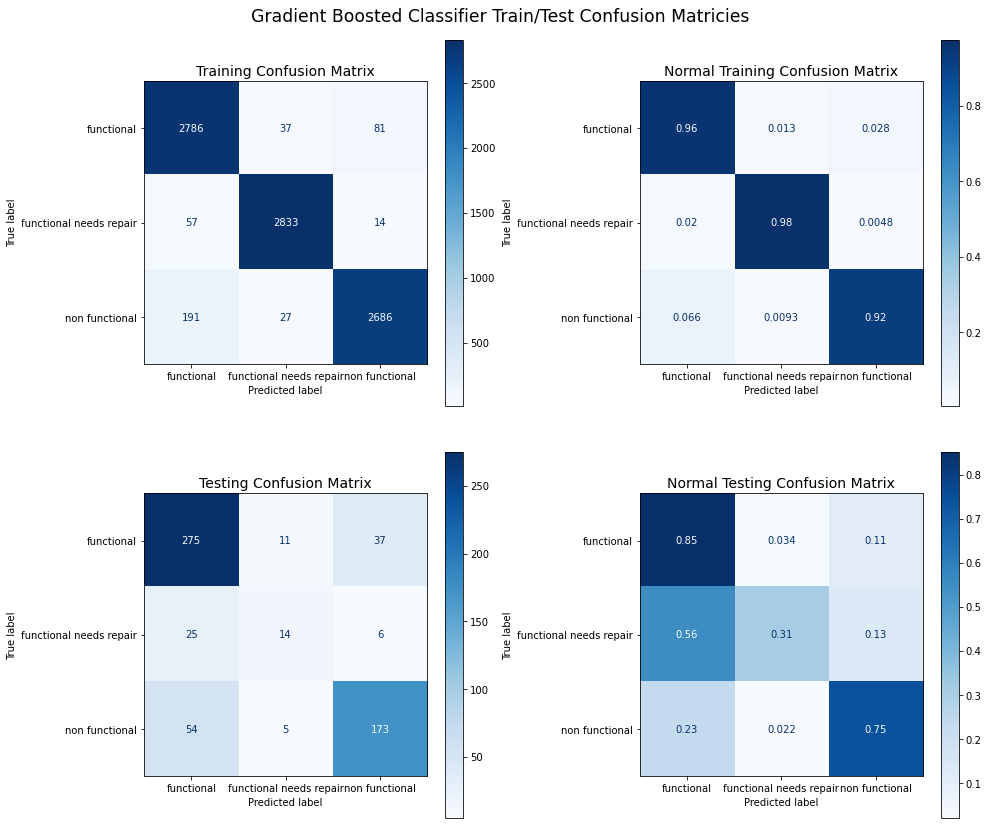

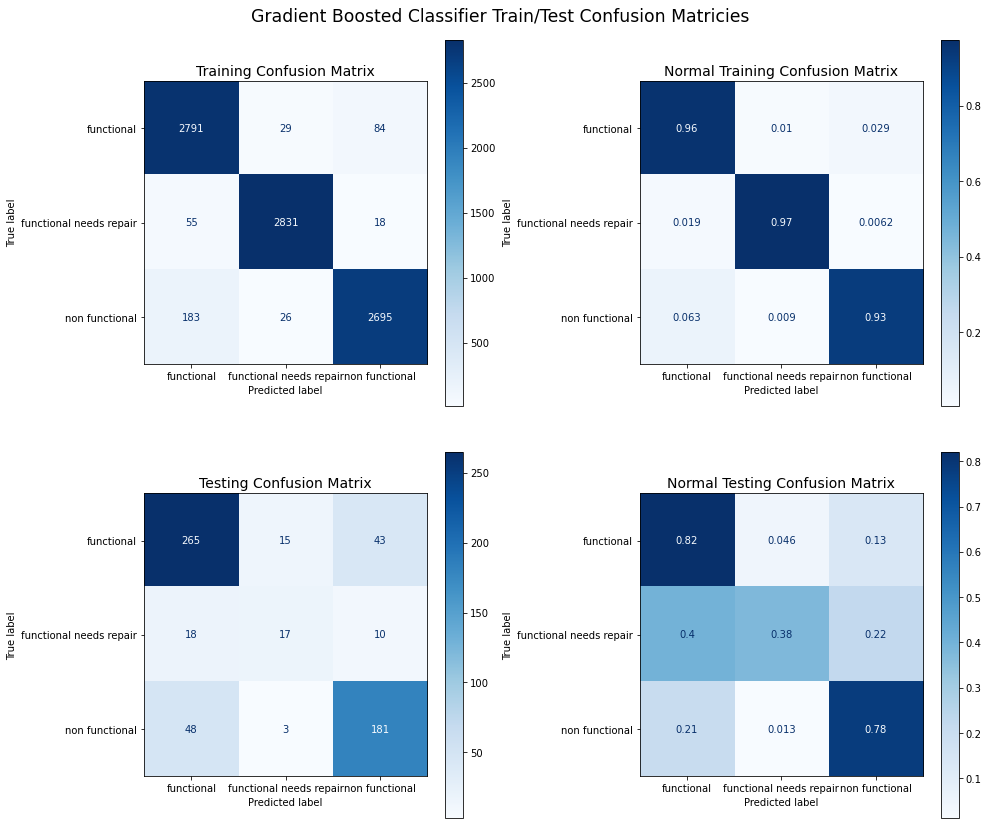

Feature  Impact Magnitude
0                         quantity_dry          0.052777
1                            longitude          0.046817
2                    construction_year          0.037015
3                             latitude          0.036376
4                      quantity_enough          0.029201
5                           gps_height          0.026128
6                        district_code          0.024611
7                waterpoint_type_other          0.024005
8                    date_recorded_day          0.023030
9              extraction_type_gravity          0.022421
10               quantity_insufficient          0.022102
11                   payment_never pay          0.021703
12                          population          0.019878
13  waterpoint_type_communal standpipe          0.019426
14                          amount_tsh          0.017709

In [141]:
testCase.models['gradientBoostedClassifier'].create_classification_reports()
testCase.models['gradientBoostedClassifier'].create_confusion_matrix()

testCase2.models['gradientBoostedClassifier'].create_classification_reports()
testCase2.models['gradientBoostedClassifier'].create_confusion_matrix()

gradFeatures = testCase.models['gradientBoostedClassifier'].get_feature_importances().sort_values('Gradient Boosted Classifier Feature Importance',
                                                                                            ascending = False).reset_index()
gradFeatures.columns = ['Feature', 'Impact Magnitude']
gradFeatures[:15]

## KNN Results

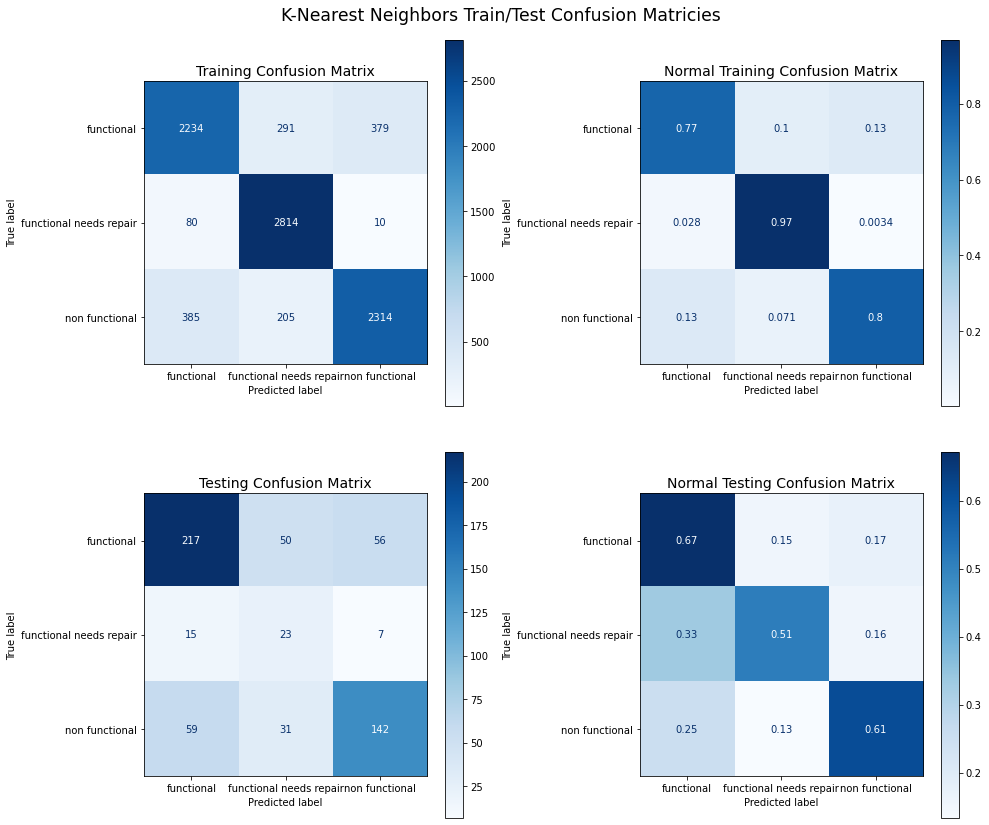

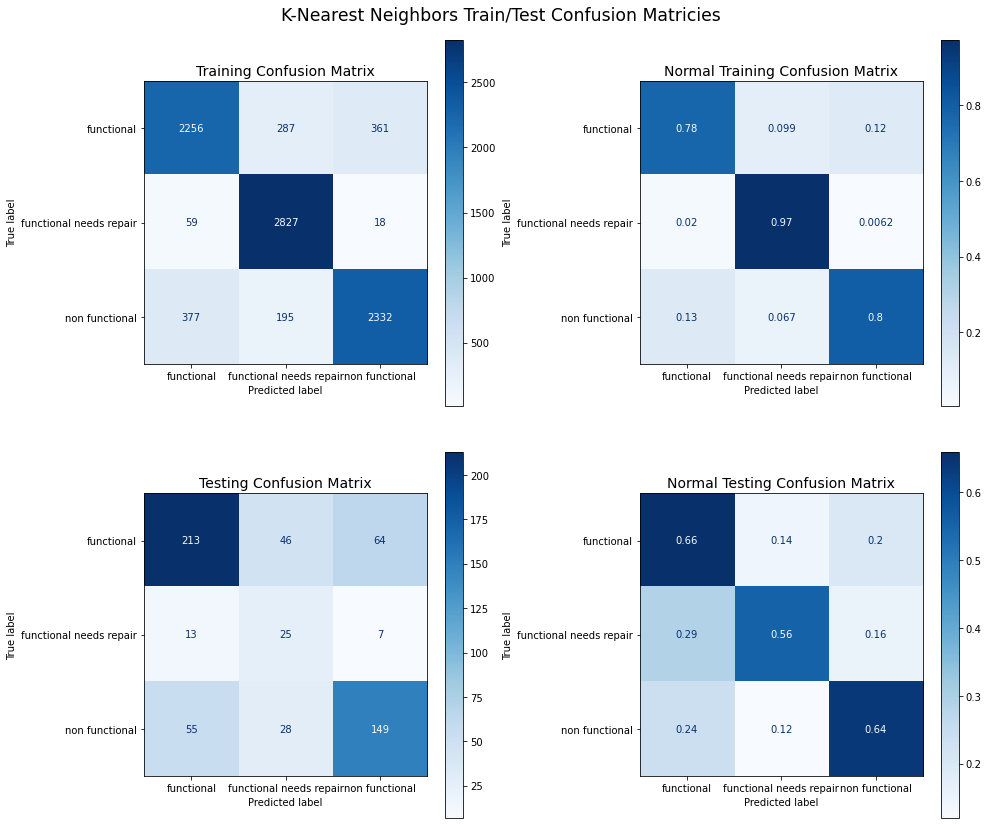

In [142]:
testCase.models['kNearestNeighborsClassifier'].create_classification_reports()
testCase.models['kNearestNeighborsClassifier'].create_confusion_matrix()

testCase2.models['kNearestNeighborsClassifier'].create_classification_reports()
testCase2.models['kNearestNeighborsClassifier'].create_confusion_matrix()

# testCase.models['kNearestNeighborsClassifier'].get_fit_model().best_estimator_

In [ ]:
shap.initjs()

In [ ]:
treeExplainer = TreeExplainer(testCase.models['randomForestClassifier'].get_fit_model().best_estimator_, 
                              testCase.X_train_preprocessed_resampled)
shaps = treeExplainer.shap_values(testCase.X_train_preprocessed_resampled, 
                                  tree_limit = 1, 
                                  from_call = True,
                                  check_additivity = False)


In [ ]:
shap.force_plot(treeExplainer.expected_value[1], shap_values=shaps[1][[0],:], feature_names=testCase.featureNames)

In [ ]:
shap.summary_plot(shaps, testCase.X_train_preprocessed_resampled)

## Random Forest Results

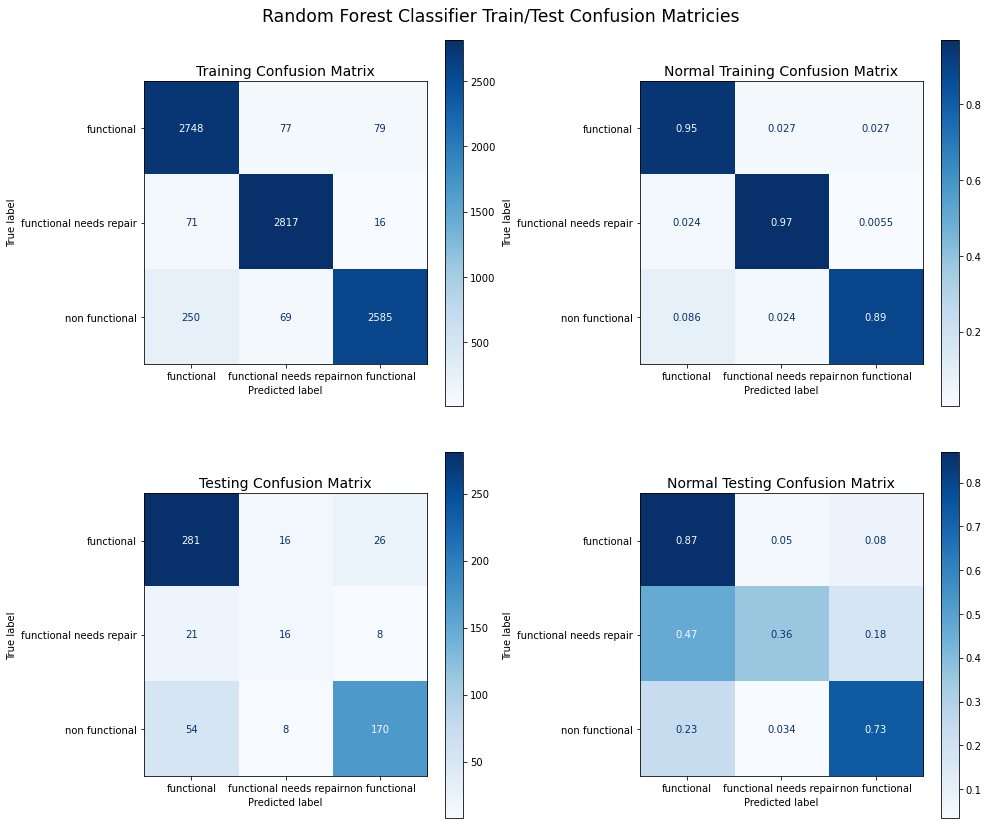

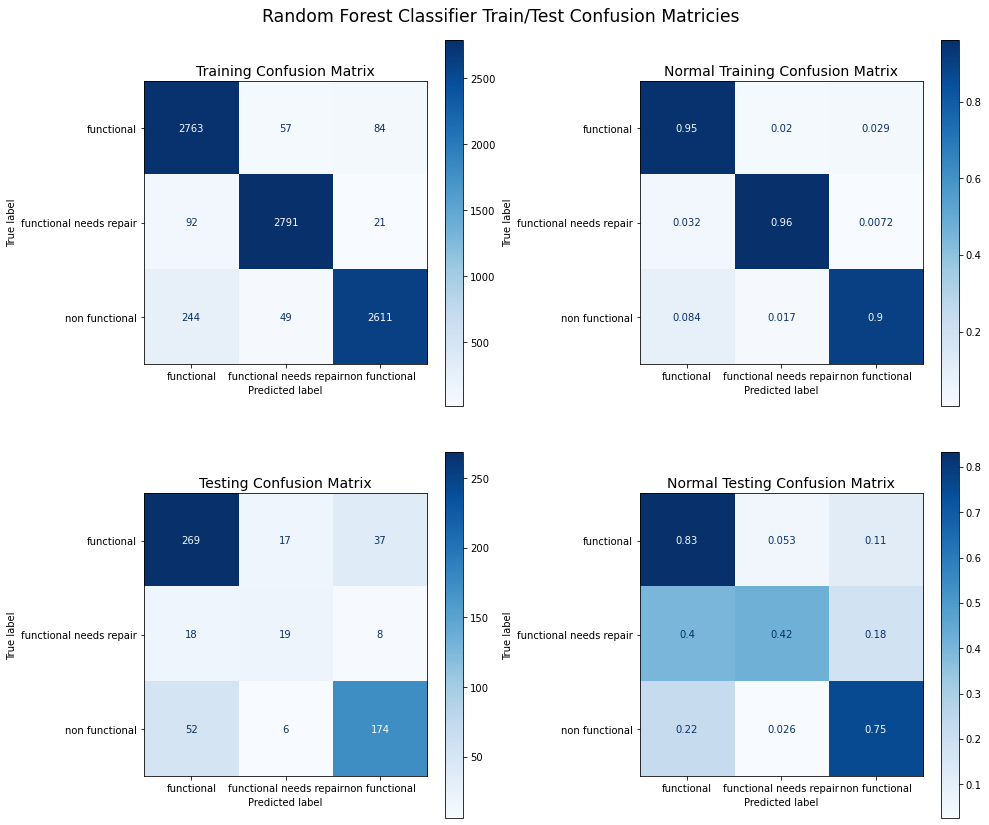

Feature  Impact Magnitude
0              quantity_dry          0.068213
1                 longitude          0.050350
2                  latitude          0.040294
3         construction_year          0.032330
4           quantity_enough          0.030677
5             district_code          0.029117
6     extraction_type_other          0.028037
7                gps_height          0.026844
8     waterpoint_type_other          0.025791
9         date_recorded_day          0.024990
10  extraction_type_gravity          0.024649
11               population          0.022519
12        payment_never pay          0.022233
13      date_recorded_month          0.019737
14               amount_tsh          0.019613

In [143]:
testCase.models['randomForestClassifier'].create_classification_reports()
testCase.models['randomForestClassifier'].create_confusion_matrix()

testCase2.models['randomForestClassifier'].create_classification_reports()
testCase2.models['randomForestClassifier'].create_confusion_matrix()

randFeatures = testCase.models['randomForestClassifier'].get_feature_importances().sort_values('Random Forest Classifier Feature Importance',
                                                                                            ascending = False).reset_index()
randFeatures.columns = ['Feature', 'Impact Magnitude']
randFeatures[:15]

## Adaboost Model

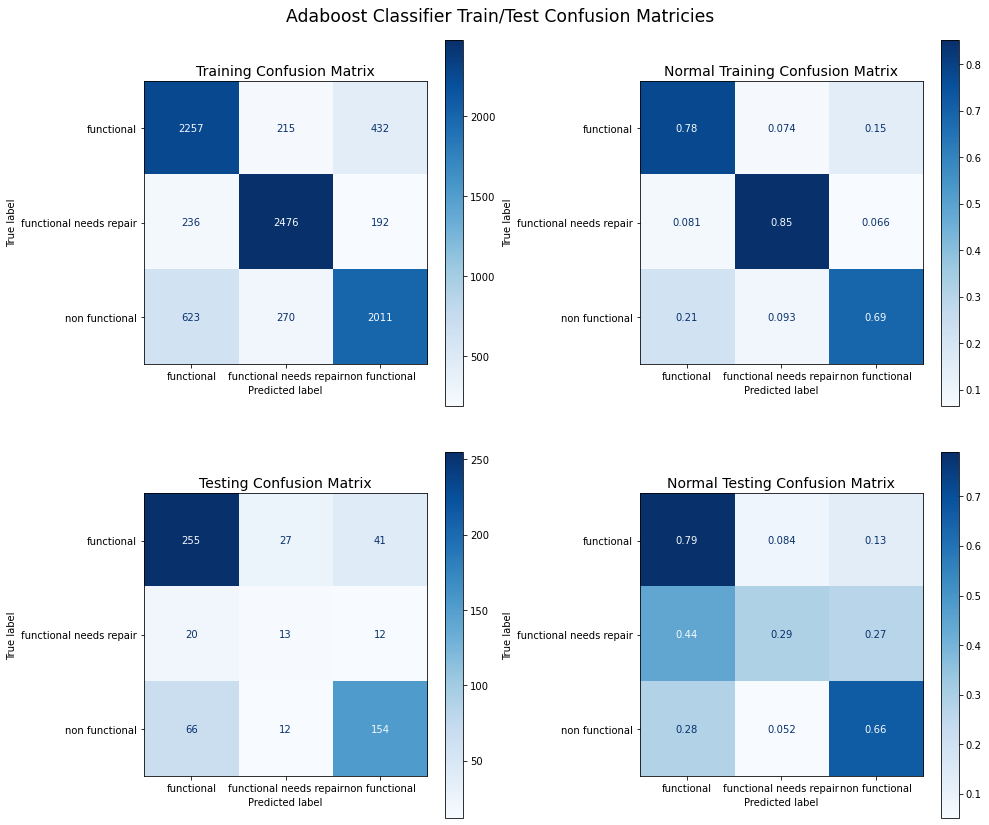

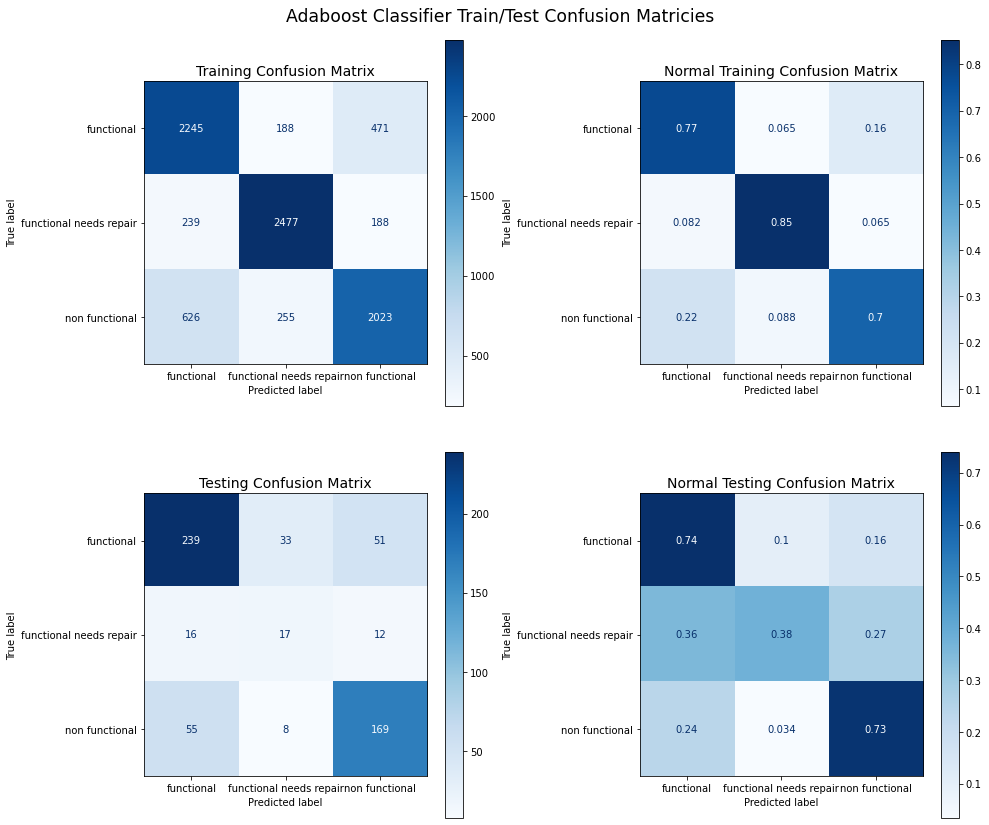

Feature  Impact Magnitude
0              quantity_dry          0.068213
1                 longitude          0.050350
2                  latitude          0.040294
3         construction_year          0.032330
4           quantity_enough          0.030677
5             district_code          0.029117
6     extraction_type_other          0.028037
7                gps_height          0.026844
8     waterpoint_type_other          0.025791
9         date_recorded_day          0.024990
10  extraction_type_gravity          0.024649
11               population          0.022519
12        payment_never pay          0.022233
13      date_recorded_month          0.019737
14               amount_tsh          0.019613

In [144]:
testCase.models['adaboostClassifier'].create_classification_reports()
testCase.models['adaboostClassifier'].create_confusion_matrix()

testCase2.models['adaboostClassifier'].create_classification_reports()
testCase2.models['adaboostClassifier'].create_confusion_matrix()

adaFeatures = testCase.models['adaboostClassifier'].get_feature_importances().sort_values('Adaboost Classifier Feature Importance',
                                                                                            ascending = False).reset_index()
randFeatures.columns = ['Feature', 'Impact Magnitude']
randFeatures[:15]

## Gaussian Naive Bayes Model

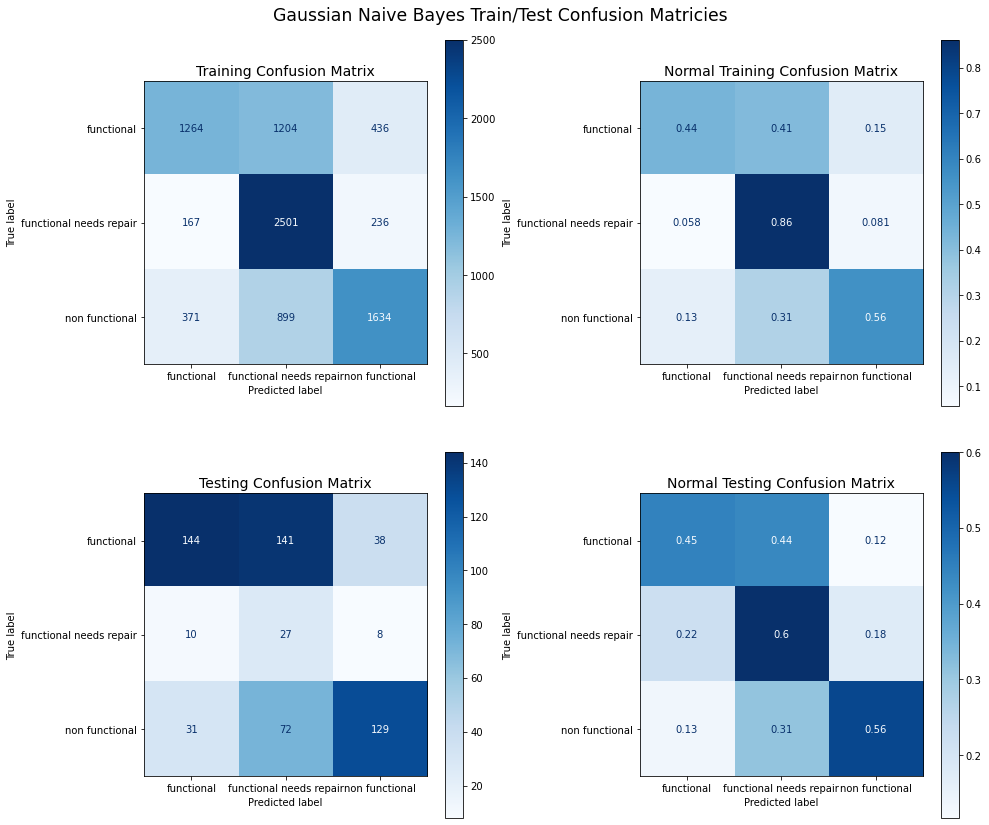

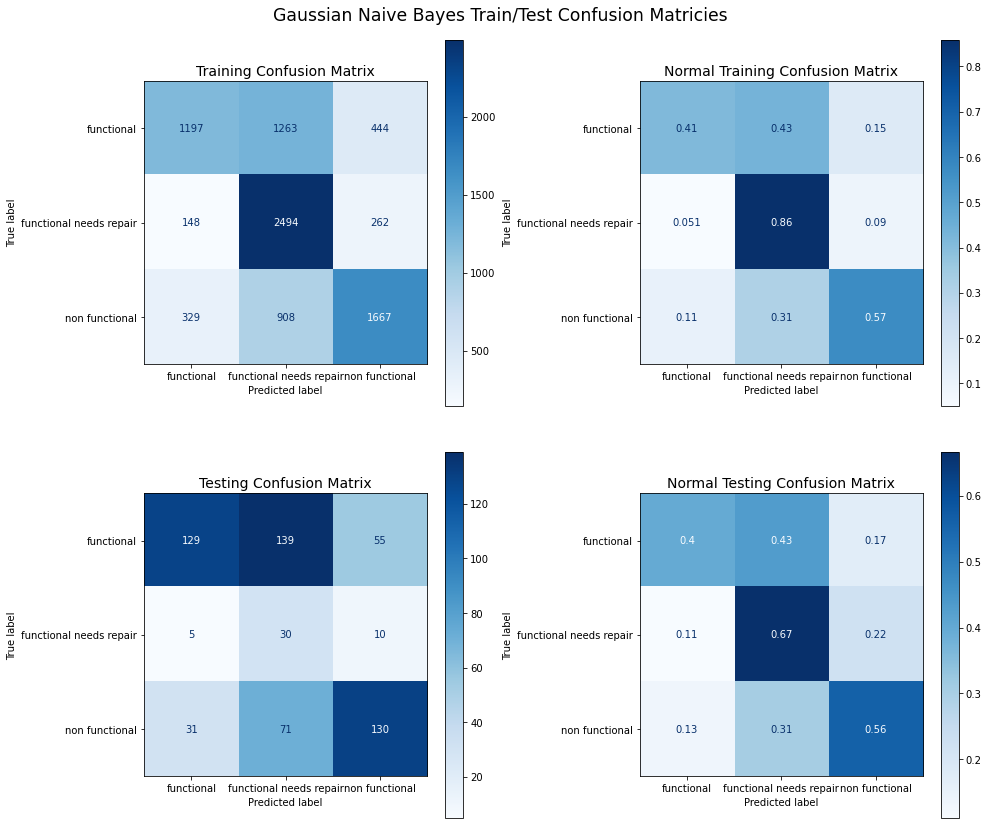

In [145]:
testCase.models['gaussianNaiveBayesClassifier'].create_classification_reports()
testCase.models['gaussianNaiveBayesClassifier'].create_confusion_matrix()

testCase2.models['gaussianNaiveBayesClassifier'].create_classification_reports()
testCase2.models['gaussianNaiveBayesClassifier'].create_confusion_matrix()

## Support Vector Machine

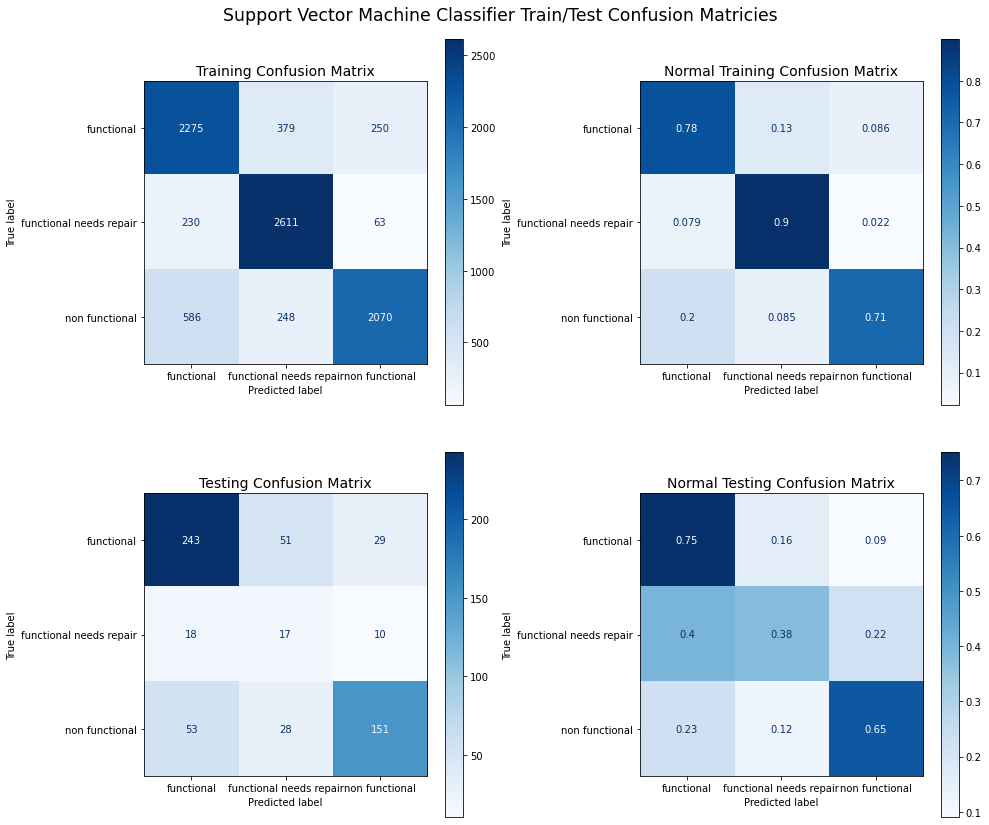

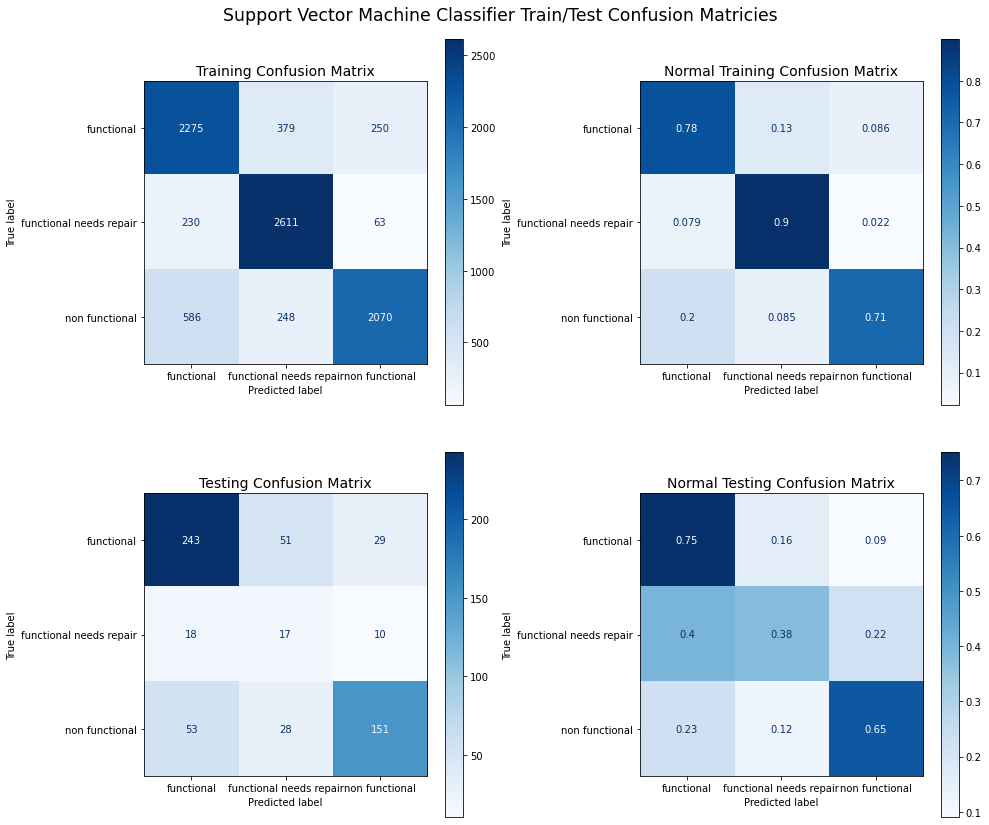

The Model Must be fit first


AttributeError: 'NoneType' object has no attribute 'sort_values'

In [146]:
testCase.models['svmClassifier'].create_classification_reports()
testCase.models['svmClassifier'].create_confusion_matrix()

testCase.models['svmClassifier'].create_classification_reports()
testCase.models['svmClassifier'].create_confusion_matrix()

svmFeatures = testCase.models['svmClassifier'].get_feature_importances().sort_values('Support Vector Machine Classifier Feature Importance',
                                                                                            ascending = False).reset_index()
svmFeatures.columns = ['Feature', 'Impact Magnitude']
svmFeatures[:15]

## Stacker

In [147]:
testStack1 = StackingClassifier(estimators = [
                                ('gradboost', testCase.models['gradientBoostedClassifier'].get_fit_model().best_estimator_),
                                ('randomForest', testCase.models['randomForestClassifier'].get_fit_model().best_estimator_),
                                ('ada', testCase.models['adaboostClassifier'].get_fit_model().best_estimator_)
                                ],
                           final_estimator = LogisticRegressionCV(penalty = 'elasticnet',
                                                                  solver = 'saga',
                                                                  n_jobs = -1,
                                                                  max_iter = 200,
                                                                  tol = .01,
                                                                  l1_ratios = [.5,.5]),
                           cv = 3,
                           n_jobs = -1)
testStack1

StackingClassifier(cv=3,
                   estimators=[('gradboost',
                                GradientBoostingClassifier(max_depth=7,
                                                           max_features='log2',
                                                           min_samples_split=5,
                                                           n_estimators=200,
                                                           subsample=0.75)),
                               ('randomForest',
                                RandomForestClassifier(max_depth=15,
                                                       min_samples_split=5,
                                                       n_estimators=200,
                                                       n_jobs=-1)),
                               ('ada',
                                AdaBoostClassifier(n_estimators=200,
                                                   random_state=1))],
                   final_estimator=LogisticRegressionCV(l1_ratios=[0.5, 0.5],
                                                        max_iter=200, n_jobs=-1,
                                                        penalty='elasticnet',
                                                        solver='saga',
                                                        tol=0.01),
                   n_jobs=-1)

In [148]:
testStack2 = StackingClassifier(estimators = [
                                ('gradboost', testCase.models['gradientBoostedClassifier'].get_fit_model().best_estimator_),
                                ('randomForest', testCase.models['randomForestClassifier'].get_fit_model().best_estimator_)],
                           final_estimator = RandomForestClassifier(n_estimators = 300,
                                                                    n_jobs = -1),
                           cv = 3,
                           n_jobs = -1)
testStack2

StackingClassifier(cv=3,
                   estimators=[('gradboost',
                                GradientBoostingClassifier(max_depth=7,
                                                           max_features='log2',
                                                           min_samples_split=5,
                                                           n_estimators=200,
                                                           subsample=0.75)),
                               ('randomForest',
                                RandomForestClassifier(max_depth=15,
                                                       min_samples_split=5,
                                                       n_estimators=200,
                                                       n_jobs=-1))],
                   final_estimator=RandomForestClassifier(n_estimators=300,
                                                          n_jobs=-1),
                   n_jobs=-1)

In [150]:
X_train = testCase.X_train_preprocessed_resampled
X_test = testCase.X_test_preprocessed
y_train = testCase.y_train_preprocessed_resampled
y_test = testCase.y_test
testStack1.fit(X_train, y_train)
testStack2.fit(X_train, y_train)
y_train_hat1 = testStack1.predict(X_train)
y_test_hat1 = testStack1.predict(X_test)
y_train_hat2 = testStack2.predict(X_train)
y_test_hat2 = testStack2.predict(X_test)
print(skm.classification_report(y_train, y_train_hat1))
print(skm.classification_report(y_test, y_test_hat1))
print(skm.classification_report(y_train, y_train_hat2))
print(skm.classification_report(y_test, y_test_hat2))

                         precision    recall  f1-score   support

             functional       0.93      0.95      0.94      2904
functional needs repair       0.98      0.97      0.98      2904
         non functional       0.96      0.93      0.94      2904

               accuracy                           0.95      8712
              macro avg       0.95      0.95      0.95      8712
           weighted avg       0.95      0.95      0.95      8712

                         precision    recall  f1-score   support

             functional       0.79      0.85      0.82       323
functional needs repair       0.47      0.33      0.39        45
         non functional       0.81      0.77      0.79       232

               accuracy                           0.78       600
              macro avg       0.69      0.65      0.67       600
           weighted avg       0.77      0.78      0.78       600

                         precision    recall  f1-score   support

             funct

# Baseline Models

To begin the analysis we break the preprocessed data up into the target and features

In [26]:
X = dfPreprocessed.copy().drop(columns = ['status_group'])
y = dfPreprocessed.copy().status_group

## Instantiate the Case and Preprocess the Data

With engineering and feature selection completed all that remains is to impute missing data and onehot encode the categorical columns. This task is much more efficient to be completed within a pipline of sci-kit learn objects and custom objects I created that are meant to support sci-kit learn operations in terms of data organization. All custom objects are well documented and attempt to follow the flow of sci-kit learn in terms of implementation. The following cell will fill and encode all the data. The method impliments the column transformer to handle the categorical and continuous features seperately. For the subsequent models, the following methodology is used:

* Continuous Features - The median is used for imputation and then all data is scaled using z-scores
* Categorical Features - The string 'missing' is used for imputation and then all data is onehot encodded

After the pipeline completes and the features of the training set and testing set have been scaled and encodded, the training features and tartet are resampled using the not majority SMOTE technique. This resamples all minority classes in a synthetic manner in order to equalize the number of samples across all target labels. 

In [27]:
# Create the model case
baselineModelCase = ModelCase(X,y, test_size=.075)

In [28]:
# Preprocess the data. This will save the preprocessed data into the case for repeatability.
baselineModelCase.preprocessing(imputationMethod = 'simple', sparse_threshold = 0)

#The builtin models must be initialized after the preprocessing because they inherit the preprocessed data 
baselineModelCase.initialize_models()

## Global Modeling Parameters
Because all of the models we are about to run are encapsulated in grid search objects, we are going to set the n_jobs and 'cv' parameters globally in our model case. Three cross validations will be the limit for all of our models. Otherwise the computational cost will become too high. 

In [29]:
# We set the following paramaters for all the models
for key in baselineModelCase.models.keys():
    baselineModelCase.models[key].set_all({
    'n_jobs' : -1,
    'cross_values' : 3,
    'scoring' : 'accuracy'
})

## Pickled Processing/Models
This section is only for retrieving and saving models.

In [63]:
# with open('data/pickled_data_round_1.pkl', 'wb') as pickle_file:
#     dill.dump([baselineModelCase.X_train_preprocessed_resampled, 
#                baselineModelCase.X_test_preprocessed,
#                baselineModelCase.y_train_preprocessed_resampled,
#                baselineModelCase.y_test,
#                baselineModelCase.featureNames], pickle_file)

In [36]:
# with open('data/pickled_data_round_1.pkl', 'rb') as pickle_file:
#     allData = dill.load(pickle_file)
# baselineModelCase.X_train_preprocessed_resampled = allData[0]
# baselineModelCase.X_test_preprocessed = allData[1]
# baselineModelCase.y_train_preprocessed_resampled = allData[2]
# baselineModelCase.y_test = allData[3]
# baselineModelCase.featureNames = allData[4]

In [62]:
# with open('pickled_models/grad_boosted_model.pkl', 'wb') as pickle_file:
#      dill.dump(baselineModelCase.models['gradientBoostedClassifier'], pickle_file)
    
# with open('pickled_models/knn_model.pkl', 'wb') as pickle_file:
#      dill.dump(baselineModelCase.models['kNearestNeighborsClassifier'], pickle_file)
    
# with open('pickled_models/random_forest.pkl', 'wb') as pickle_file:
#      dill.dump(baselineModelCase.models['randomForestClassifier'], pickle_file)
    
# with open('pickled_models/adaboost_model.pkl', 'wb') as pickle_file:
#      dill.dump(baselineModelCase.models['adaboostClassifier'], pickle_file)
    
# with open('pickled_models/naive_bayes_model.pkl', 'wb') as pickle_file:
#      dill.dump(baselineModelCase.models['gaussianNaiveBayesClassifier'], pickle_file)
        
# with open('pickled_models/svm_model.pkl', 'wb') as pickle_file:
#      dill.dump(baselineModelCase.models['svmClassifier'], pickle_file)

In [37]:
# with open('pickled_models/grad_boosted_model.pkl', 'rb') as pickle_file:
#     baselineModelCase.models['gradientBoostedClassifier'] = dill.load(pickle_file)
    
# with open('pickled_models/knn_model.pkl', 'rb') as pickle_file:
#     baselineModelCase.models['kNearestNeighborsClassifier'] = dill.load(pickle_file)
    
# with open('pickled_models/random_forest.pkl', 'rb') as pickle_file:
#     baselineModelCase.models['randomForestClassifier'] = dill.load(pickle_file)
    
# with open('pickled_models/adaboost_model.pkl', 'rb') as pickle_file:
#     baselineModelCase.models['adaboostClassifier'] = dill.load(pickle_file)
    
# with open('pickled_models/naive_bayes_model.pkl', 'rb') as pickle_file:
#     baselineModelCase.models['gaussianNaiveBayesClassifier'] = dill.load(pickle_file)
    
# with open('pickled_models/naive_bayes_model.pkl', 'rb') as pickle_file:
#     baselineModelCase.models['svmClassifier'] = dill.load(pickle_file)

## Gradient Boosted Classification Model
We will include a gradient boosted model in the baseline model round becase it is a consistant and powerful tool that is known to achieve high metrics results.

### Set Parameter Grid
We set up the following parameter list to explore hyper-parameter tunning. The most powerful parameters are the learning rate, max depth and n_estimators parameters. Gradient boosted models tend to overfit so the mex depth parameter is limited to a max of 7. Because the encodded data has nearly 200 features, we keep the learning rate low to encourage model convergance. With a high amount of features the data points are more seperated which makes detection more difficult and larger learning rates will increase the likelihood of missing optimal solutions. The other parameters are being tuned as a matter of course, just in case there are certain combinations that increase model performace.

In [30]:
baselineModelCase.models['gradientBoostedClassifier'].set_parameter_grid({
     'learning_rate': [.001,0.1,.1],
     'max_depth': [3,5,7],
     'max_features': ['log2', None],
     'max_leaf_nodes': [None],
     'min_samples_split': [5],
     'n_estimators': [200],
     'subsample': [.25,.5, .75]
})

### Fit and Predict

In [31]:
baselineModelCase.models['gradientBoostedClassifier'].fit()
baselineModelCase.models['gradientBoostedClassifier'].predict()

### Gradient Boosted Reports
We generate a standard classification report as well as confustion matricies for both training and testing set

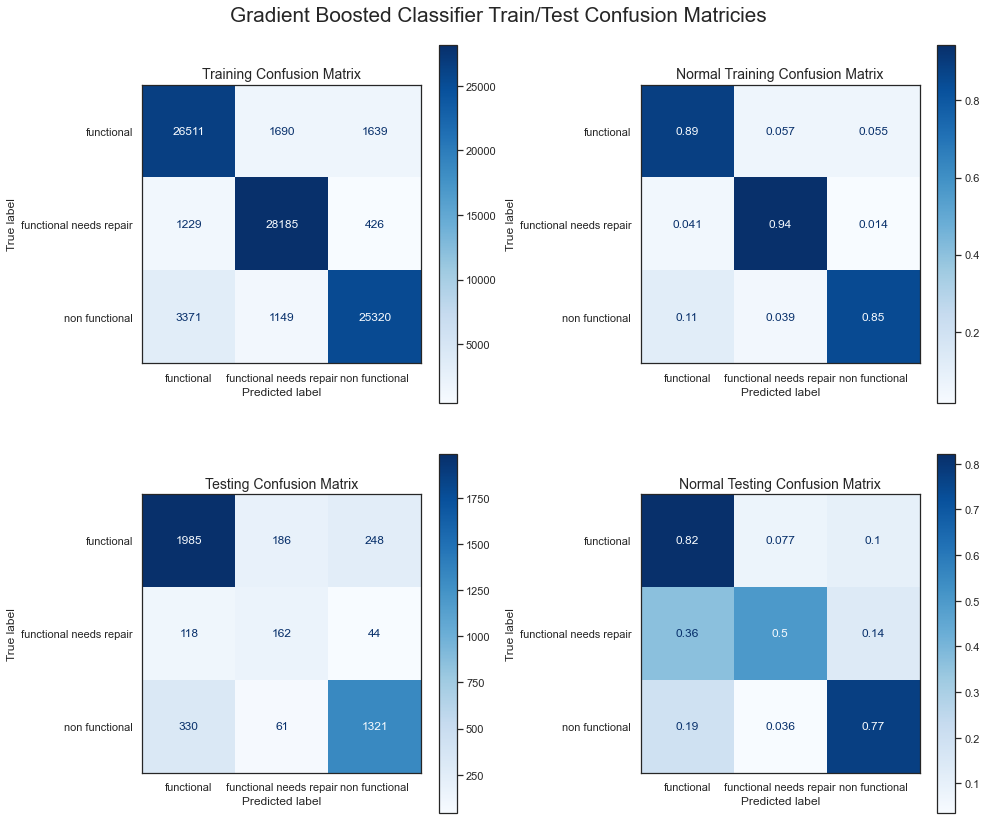

In [54]:
sns.set_context('notebook')
sns.set_style('white')
baselineModelCase.models['gradientBoostedClassifier'].create_classification_reports()
baselineModelCase.models['gradientBoostedClassifier'].create_confusion_matrix()

### Feature Importance
One of the most useful aspects of models is the ability to assign feature importance. Feature importance associates relative numbers to each feature as a means of quantifying how useful each parameter was in determining predictions. These coefficients can be a great way to glearn simplified understanding of the relationship between the features and the target variable.

In [55]:
gradFeatures = baselineModelCase.models['gradientBoostedClassifier'].get_feature_importances().sort_values('Gradient Boosted Classifier Feature Importance',
                                                                                            ascending = False).reset_index()
gradFeatures.columns = ['features', 'importance_magnitude']
gradFeatures[:15]

features  importance_magnitude
0              quantity_dry              0.113729
1                 longitude              0.079858
2                  latitude              0.059778
3         construction_year              0.046802
4     waterpoint_type_other              0.035922
5         date_recorded_day              0.034759
6             district_code              0.034265
7   extraction_type_gravity              0.034124
8                gps_height              0.031395
9           quantity_enough              0.028792
10    quantity_insufficient              0.024511
11         region_Shinyanga              0.022031
12        payment_never pay              0.019851
13    extraction_type_other              0.019709
14            source_spring              0.018244

### Evaluation

## K-Nearest Neighbors Model
K-Nearest Neighbors is a vanilla tree model. Because this method doesn't calculate submodels it tends to overfit. The reason we include it is the possibility that the tree detects specific patterns that might be lost in ensemble methods that use aggregated descisions to determine the model predictions.

### Set Parameter Grid
The parameter grid is more straight forward for a single tree. The two parameters tuned here are the total number of allowed leaves and number of neighbors that vote for the classification. If unrestricted, the leaves will likely grow to the length of the number of unique entries in the dataset, so a restriction is necessary. Because our data has many features, we will include 40 and 50 as leaf options which are more than the normal 30 default. The number of neighbors parameter is also increased to 10. With more data points aiding in the classification task 10 neighbors should act as a slight buffer against massive overfitting.

In [34]:
KNeighborsClassifier()
baselineModelCase.models['kNearestNeighborsClassifier'].set_parameter_grid({
     'algorithm': ['auto'],
     'leaf_size': [30, 40, 50],
     'n_jobs': [-1],
     'n_neighbors':[5,10],
     'weights': ['uniform']
})

### Fit and Predict

In [35]:
baselineModelCase.models['kNearestNeighborsClassifier'].fit()
baselineModelCase.models['kNearestNeighborsClassifier'].predict()

K-Nearest Neighbors does not support feature importance


### Reports
We generate a standard classification report as well as confustion matricies for both training and testing set

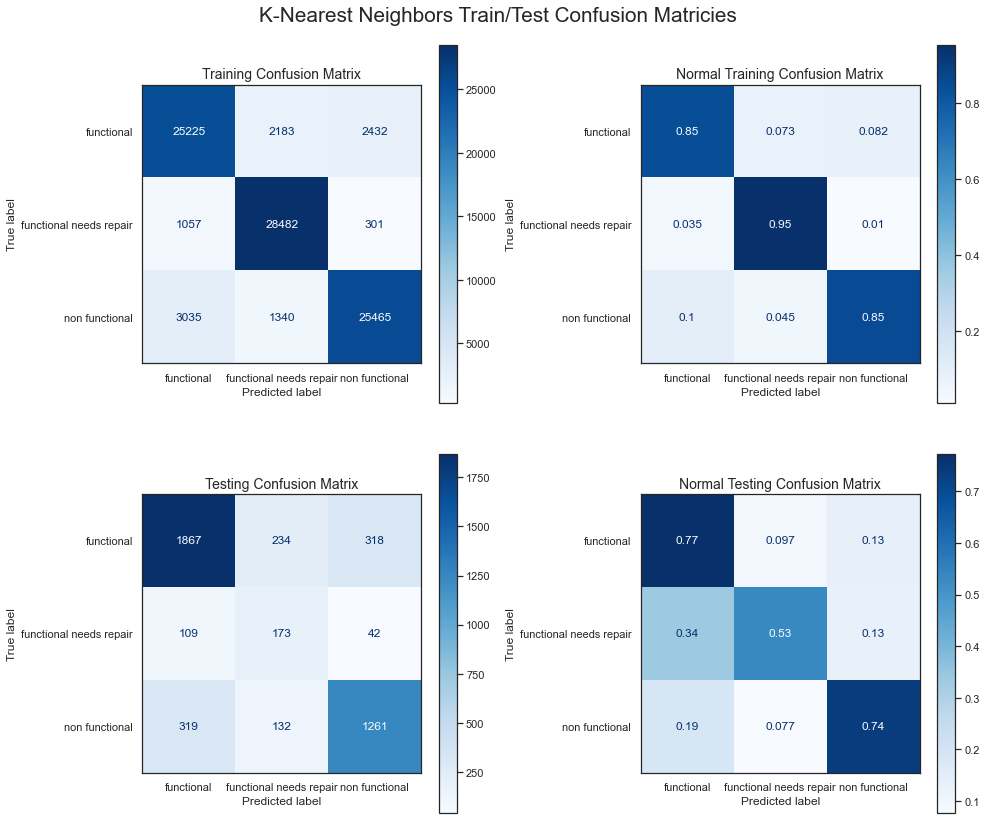

In [56]:
baselineModelCase.models['kNearestNeighborsClassifier'].create_classification_reports()
baselineModelCase.models['kNearestNeighborsClassifier'].create_confusion_matrix()

### Feature Importance
The Sklearn KNearestClassifier object doesn't support feature importance at this time. It is possible to pull out feature information from tree models by counting the number of samples that pass through a given decision node. This is warranted in future research.

### Evaluation

## Ranom Forest Model
Also a tree based model. Random forests are more robust to overfitting than gradient boosted models. For this reason it is also included in the analysis, hopefully to compensate for any overfitting. 

### Set Parameter Grid
The main parameters for this modela are number of estimators, criterion and max depth. Criterion is the most striaght forward as it is the formula used to judge where and when the tree should be split. There are only two options so trying both covers all the bases. The number of estimators if th eoverall number of trees that will be created and will get to vote on the final predictions. The more trees typically means more accurate, however, this approach also deceases the ability to detect minority outcomes which get outvoted as the number increases. For this reason we include 50 as well as the standard 100 and increased amount of 200. Max depth is the number of branches any one path on the tree is allowed to make. Like a KNearestClassifier, uncapped this number will typically grow large as the the tree converges to seperating out individual rows. For this reason, we will cap the depth at a max of 20. In general 20 is considered to be a deep tree, but, given our data set as 200 features, this depth shouldn't in overfitting. 

In [37]:
baselineModelCase.models['randomForestClassifier'].set_parameter_grid({
    'n_estimators':[50,100,200],
    'criterion':['gini', 'entropy'],
    'max_depth':[10,15, 20],
    'min_samples_split':[1,5],
    'n_jobs':[-1],
})

### Fit and Predict

In [38]:
baselineModelCase.models['randomForestClassifier'].fit()
baselineModelCase.models['randomForestClassifier'].predict()

### Reports
We generate a standard classification report as well as confustion matricies for both training and testing set

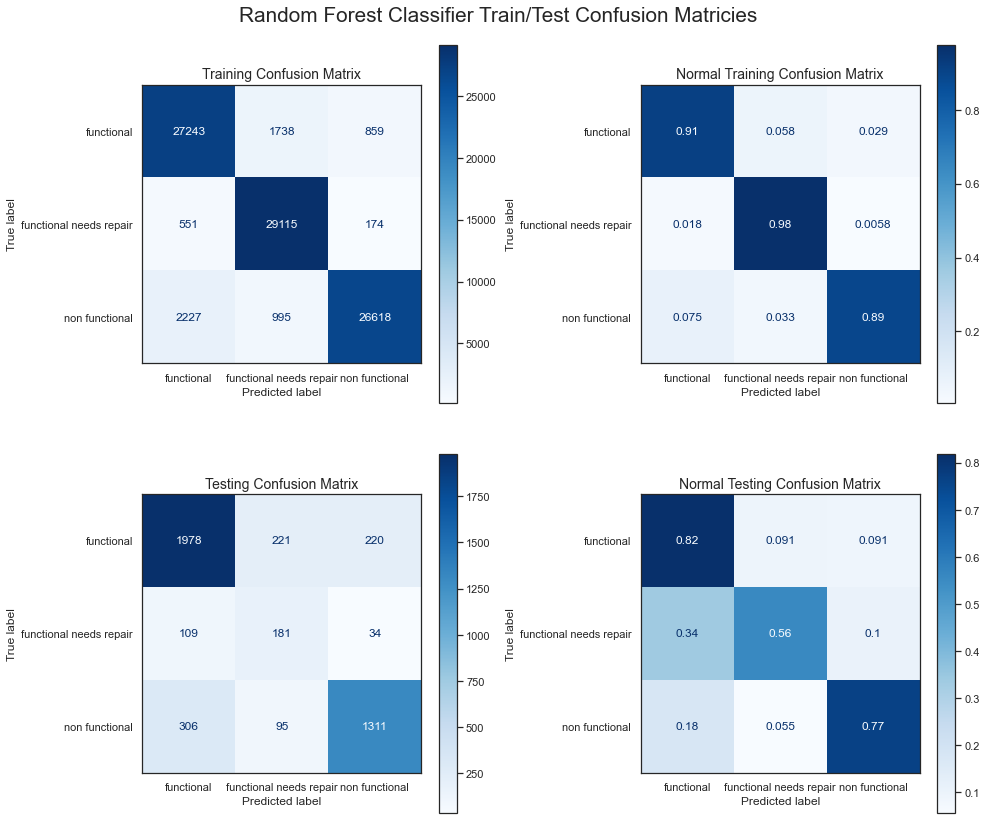

In [57]:
baselineModelCase.models['randomForestClassifier'].create_classification_reports()
baselineModelCase.models['randomForestClassifier'].create_confusion_matrix()


### Feature Importance
Luckily, random forests are supported models for a python package caled shap. There will be more info on shap in the final conclusion section. Shap is a tool specifically designed to provide substantial insight in how features play a role in the prediction step. The following cell will provide a magnitude summary of what features were used in the models predictions. While usful, shap is a summation calculation which means it gives information about how important a feature is, not what the exact relationship between the feature and the target is. 

100%|===================| 268450/268560 [09:34<00:00]        

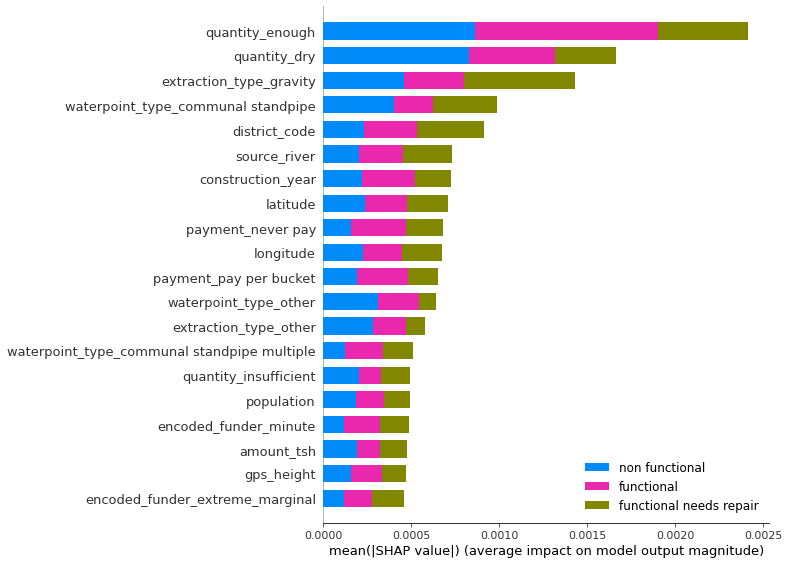

In [182]:
treeExplainer = TreeExplainer(baselineModelCase.models['randomForestClassifier'].get_fit_model().best_estimator_, 
                              baselineModelCase.X_train_preprocessed_resampled)
shaps = treeExplainer.shap_values(baselineModelCase.X_train_preprocessed_resampled, 
                                  tree_limit = 3, 
                                  from_call = True,
                                  check_additivity = False)
shap.summary_plot(shaps, 
                  baselineModelCase.X_train_preprocessed_resampled, 
                  feature_names=baselineModelCase.featureNames,
                  class_names= baselineModelCase.models['randomForestClassifier'].get_fit_model().classes_)

To provide a quick breakdown case. Here are the shap values for a single prediction. Don't be alarmed if the quantities displayed are foreign. What's important to keep track of for shap values are the relative sizes of hte values. 

In [187]:
shap.initjs()
shap.force_plot(treeExplainer.expected_value[0], 
                shap_values=shaps[0][[1],:], 
                feature_names=baselineModelCase.featureNames)

## Support Vector Machine Model
The last model we will be considering is a support vector machine classifier. Admittedly, SVMs are less effective as the dimensionality of the sample space increases which will likely mean it is not the right choice of a model for this data. The reason it's being included is to have a non-tree model be part of the discussion. The diversity in modeling may provide something usful for a final analysis, even if the individual model isn't incredibly strong. 

### Set Parameter Grid

The important parameters for SVMs are kernel and C. Kernel is the type of underlying process that is driving the decisions. We will be looking at radial and logistic kernels which group data points in distinct ways. As for the C parameter (learning rate), we will cover three orders of parameters. Because the sample space, getting the SVM to fully converge on a final model might be tricky so we provide a wide range for this parameter, hoping one of them will work out.  

In [40]:
baselineModelCase.models['svmClassifier'].set_parameter_grid({
 'C': [.1, 1, 10],
 'decision_function_shape': ['ovr'],
 'kernel' : ['rbf', 'sigmoid'],
 'gamma' : ['scale', 'auto'],
 'max_iter': [5000],
 'tol' : [.1]
})

### Fit and Predict

In [41]:
baselineModelCase.models['svmClassifier'].fit()
baselineModelCase.models['svmClassifier'].predict()

Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Support Vector Machine Classifier does not support feature importance


### Reports
We generate a standard classification report as well as confustion matricies for both training and testing set

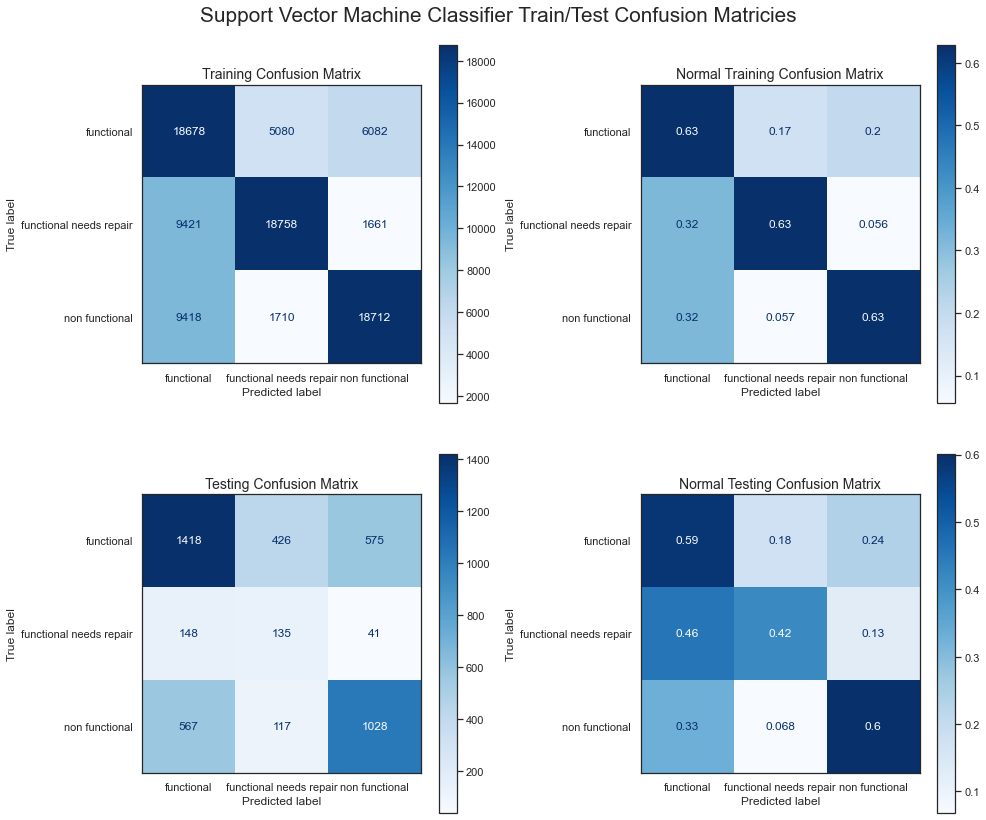

In [58]:
baselineModelCase.models['svmClassifier'].create_classification_reports()
baselineModelCase.models['svmClassifier'].create_confusion_matrix()

### Feature Importance
SVMs also do not support feature importances. This primarily has to do with the way the model makes decisions, as it is more dependant on the spacial configuration of the data and not necessarily the labels we give to the data. 

### Evaluation

## Modeling Summay

The results iluminate a detection issue for the minority class as all the models overfit the needs_repair category in the training data. There could be several reasons for the overfitting including the method of feature engineering, hyper-parameters, or little difference in the actual target class predictors. Ultimately, increasing preformace of the minority class metrics without comprimising overal model preformace may not be possible.

Moving Forward we can adjust the

An assessment of the baseline models leads me to conclude the follow types should be selected for the final modeling portion:
* Gradient Boosted Classifier -- The Best Performing Model Overall with the highest precision for the minority class
* Random Forest Classifier -- Well preforming model that has the second strongest recall for the minority class

# Final Models

We're finally here! We have several working models listed below that will be fed into the our stacking classifier. The stacking classifier is a bundle that takes the guesses of the individual models and treats them as features to be fed into a final model. The final model is trained on these new columns and makes a final prediction based on the individual guesses for the testing set. 

The best models from the baseline gridsearches are the models which will be used in the final estimators

In [43]:
baselineModelCase.models['gradientBoostedClassifier'].get_fit_model().best_estimator_

GradientBoostingClassifier(max_depth=7, min_samples_split=5, n_estimators=200,
                           subsample=0.75)

In [44]:
baselineModelCase.models['randomForestClassifier'].get_fit_model().best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_split=5,
                       n_estimators=200, n_jobs=-1)

## Stacking Classifiers
The two cells below contain the logic of the stacking classifiers to be used. The first stack is going to use a Logistic Regression as the final model to bring everything together. The second stack will add another randomforest as the final estimator. We use two stacks to cover both a regression type and tree type final estimator. Note that we do not need to check the Logistic Regressor for the assumptions of linear modeling 

In [45]:
stack1 = StackingClassifier(estimators = [
                                ('gradboost', baselineModelCase.models['gradientBoostedClassifier'].get_fit_model().best_estimator_),
                                ('randomForest', baselineModelCase.models['randomForestClassifier'].get_fit_model().best_estimator_)],
                           final_estimator = LogisticRegressionCV(penalty = 'elasticnet',
                                                                  solver = 'saga',
                                                                  n_jobs = -1,
                                                                  max_iter = 200,
                                                                  tol = .01,
                                                                  l1_ratios = [.5,.5]),
                           cv = 3,
                           n_jobs = -1)

In [46]:
stack2 = StackingClassifier(estimators = [
                                ('gradboost', baselineModelCase.models['gradientBoostedClassifier'].get_fit_model().best_estimator_),
                                ('randomForest', baselineModelCase.models['randomForestClassifier'].get_fit_model().best_estimator_)],
                           final_estimator = RandomForestClassifier(n_estimators = 300),
                           cv = 3,
                           n_jobs = -1)

For Simplicity we will reassign some names so the cell lengths don't get untenable

In [47]:
# Reassign all training and testing data
X_train = baselineModelCase.X_train_preprocessed_resampled
X_test = baselineModelCase.X_test_preprocessed
y_train = baselineModelCase.y_train_preprocessed_resampled
y_test = baselineModelCase.y_test

## Fitting the Stackers
Here we fit the stackers and use their fitted versions to make our last set of predictions.

In [48]:
# Fit the stackers
stack1.fit(X_train, y_train)
stack2.fit(X_train, y_train)

StackingClassifier(cv=3,
                   estimators=[('gradboost',
                                GradientBoostingClassifier(max_depth=7,
                                                           min_samples_split=5,
                                                           n_estimators=200,
                                                           subsample=0.75)),
                               ('randomForest',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=20,
                                                       min_samples_split=5,
                                                       n_estimators=200,
                                                       n_jobs=-1))],
                   final_estimator=RandomForestClassifier(n_estimators=300),
                   n_jobs=-1)

In [49]:
# Get training and testing set predictions for both stacks
y_train_hat1 = stack1.predict(X_train)
y_test_hat1 = stack1.predict(X_test)
y_train_hat2 = stack2.predict(X_train)
y_test_hat2 = stack2.predict(X_test)

### Pickling stackers

In [61]:
with open('pickled_models/stack.pkl', 'wb') as pickle_file:
    dill.dump(stack1, pickle_file)
with open('pickled_models/stack2.pkl', 'wb') as pickle_file:
    dill.dump(stack2, pickle_file)

In [257]:
# with open('pickled_models/stack.pkl', 'rb') as pickle_file:
#     stack1 = dill.load(pickle_file)
# with open('pickled_models/stack2.pkl', 'rb') as pickle_file:
#     stack2 = dill.load(pickle_file)

## Stacker Reports
The stacker is an object outside of our model case so we very quickly code up the styling for the classification report so that it matches the previous ones. 

In [50]:
# Quick and dirty classification report generation

# Create our classification reports
dfStack1Train = pd.DataFrame().from_dict(skm.classification_report(y_train, y_train_hat1, output_dict = True))
dfStack1Test = pd.DataFrame().from_dict(skm.classification_report(y_test, y_test_hat1, output_dict = True))
dfStack2Train = pd.DataFrame().from_dict(skm.classification_report(y_train, y_train_hat2, output_dict = True))
dfStack2Test = pd.DataFrame().from_dict(skm.classification_report(y_test, y_test_hat2, output_dict = True))

# define  a quick styleing function to match the previous reports
def quick_style(df, whichSet):
    '''
    Function that add some basic style to a dataframe
    
    Parameters -- pd.DataFrame() object
    '''
    return (df
            .style
            .background_gradient(cmap = 'Blues' ,axis = 1)
            .set_caption(f'Stack {whichSet} Report')
            .set_table_styles([
                               {'selector' : 'caption',
                               'props' : [('text-align',  'center'),
                                          ('font-size',  '18px')]},
                               {'selector' : 'table',
                               'props' : [('margin','auto')]}]))


### Stack 1 Reports

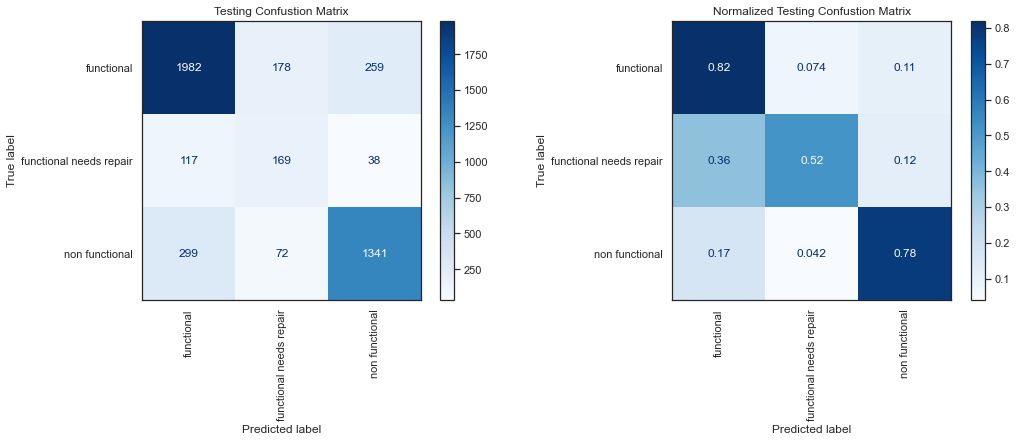

In [59]:
#Display the classification report for the first stack
display (quick_style(dfStack1Train, 'Train'))
display (quick_style(dfStack1Test, 'Test'))
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (15,6))
skm.plot_confusion_matrix(
    stack1,
    X_test, 
    y_test, 
    cmap = 'Blues', 
    xticks_rotation='vertical',
    ax = ax1
)
ax1.set(title = 'Testing Confustion Matrix')
skm.plot_confusion_matrix(
    stack1,
    X_test, 
    y_test, 
    cmap = 'Blues', 
    xticks_rotation='vertical',                
    normalize='true',
    ax = ax2
)
ax2.set(title = 'Normalized Testing Confustion Matrix')

plt.tight_layout()
plt.show()

### Stack 2 Report

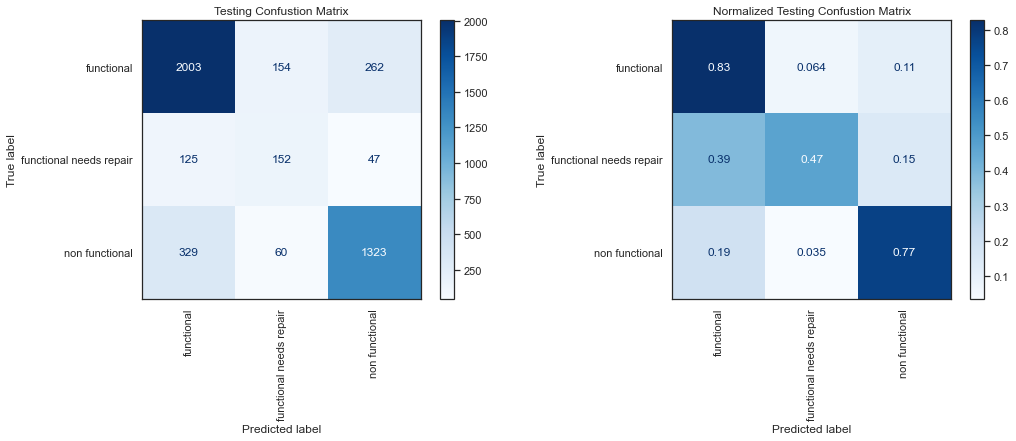

In [60]:
# display the classification reports for the second stack
display (quick_style(dfStack2Train, 'Train'))
display (quick_style(dfStack2Test, 'Test'))
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (15,6))
skm.plot_confusion_matrix(
    stack2,
    X_test, 
    y_test, 
    cmap = 'Blues', 
    xticks_rotation='vertical',
    ax = ax1
)
ax1.set(title = 'Testing Confustion Matrix')
skm.plot_confusion_matrix(
    stack2,
    X_test, 
    y_test, 
    cmap = 'Blues', 
    xticks_rotation='vertical',                
    normalize='true',
    ax = ax2
)
ax2.set(title = 'Normalized Testing Confustion Matrix')

plt.tight_layout()
plt.show()

# Final Evaluation / Conclusions


## Overview
The Stackers have preformed somewhat admirably, only adding on another tenth to the gradient boosted predictions. This work seems silly when compared to the effort but every little bit counts! Despite our best efforts to increase the detection and precision of the minority class, the ultimate result is underwhelming. Going off of F1 score, stack1 was able to max out at 44%. Thus the minority class will need to be the subject of further study in future examinations. It should be noted that because the stacks have f1 > 33% this does suggest the model is picking some amount of the minority class. Whether the poor result is due to noise, engineering or lack of samples is still unknown.

Looking at the other results there doesn't appear to be an issue with overfitting. Our training metrics are high but not high enough that the discrepancy between the testing set is glaring (with the exception of the minority class). 

## Features
All models with supported feature importance methods appear to be calling out the same categories, although with some debate as to the order. As for recommendations it would be wise to stick to the shap values presented by the Random Forest Model. Shap values are a technical Game Theory approch to understanding feature importance. Shap associates quantities to every feature through a one vs all analysis. This analysis estimates the impact a feature has on the outcome of every row in the data set by preforming calulation with that without said feature, whereby using the difference in score to determine relative strengths. Further discussion of the Shap method is out of the scope of this analysis but the following graph deonstrates the summary results.

In [202]:
# Instantiate the TreeEcplainer class from the shap API
treeExplainer = TreeExplainer(baselineModelCase.models['randomForestClassifier'].get_fit_model().best_estimator_, 
                              baselineModelCase.X_train_preprocessed_resampled)

# Calculate the shap values
shaps = treeExplainer.shap_values(baselineModelCase.X_train_preprocessed_resampled, 
                                  # tree limit is kept at three to make the calcs reasonable
                                  tree_limit = 3, 
                                  from_call = True,
                                  check_additivity = False)

100%|===================| 268136/268560 [09:44<00:00]        

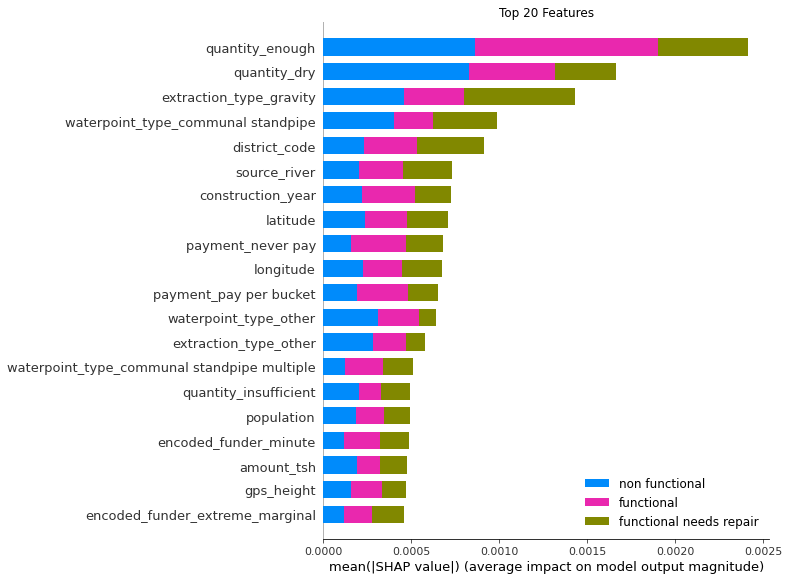

In [213]:
# use the shap summary_plot API to generate the feature importance graph
fig,axes = plt.subplots(1,1)
axes = shap.summary_plot(
                  shaps, 
                  baselineModelCase.X_train_preprocessed_resampled, 
                  show = False,
                  title = 'Shap Values for the 20 Most Important Features',
                  feature_names=baselineModelCase.featureNames,
                  class_names= baselineModelCase.models['randomForestClassifier'].get_fit_model().classes_)
plt.title('Top 20 Features');

While useful for establishing what features need further inspection, the summary graph doesn't give insight as to what effect the features has on the classification prediction. In order to determine this, we must investigate the individual features more closely. We will explore the top few below.

### Categorical Feature Importance
It makes sense to break up the analysis over data types because of the label frequencies we'll be dealing with when attempting to project the original data onto one column at a time. We will present visuals and a short analysis for each of the top 20 features. We define a quick function to reduce the redundant graphing code that will be used for all the categorical comparisons. 

In [99]:
# add an extra column to the data for the comparison visual in the next function. 
dfPreprocessed['all_wells'] = ['all_wells' for x in range(dfPreprocessed.shape[0])]

In [103]:
def plot_continuous_comparison(data, target, columnList, colorDict, verticalLAbels = False):
    '''
    A function used to plot a comparison of the target variable distribution 
    compared to the target distribution when sliced by a specific 
    label for a categorical column. The function takes a tuple of the 
    categorical column of interest with the specific label wanting to
    be sliced by. The function also needs a color map to assign to the 
    target variable distribution.
    
    Parameters:
    
        data -- pd.DataFrame object
        
        target -- Target Column in pd.DataFrame object
        
        columnList -- list of column names used to 
                      compare subgroup distribution to un-sliced
                      target variale distribution.
                            
        colorMap -- dictionary used for color map of target variable 
                    distribution. See matplotlib.pyplot.colors for more
                    information.
    
    Returns:
        
        None
    
    Displays/Prints:
    
        plt.subplots object with 2 axes. See matplotlib.pyplot documentation
        for more information
        
    '''
    # loop though all the columns in columnList and create the visuals
    listOfFigs = []
    for column in columnList:
                
        #instantiate the figure gridspec object with 2 axes
        fig= plt.figure(figsize = (20,20))
        gs = GridSpec(4,5, figure=fig)
        ax1 = fig.add_subplot(gs[0:2,:])
        ax2 = fig.add_subplot(gs[2:5,0:3])
        ax3 = fig.add_subplot(gs[2:5, 3:6])
        
        # create breakout visual for continuous variable
        sns.histplot(
            data = data,
            x = data[column],
            hue = data[target],
            multiple = 'dodge',
            ax = ax1,
            palette=  colorDict
        )
        
        # create visual that shows proportions of the various bins
        sns.histplot(
            data = data,
            x = data[column],
            hue= data[target],
            multiple = 'fill',
            palette = colorDict,
            ax = ax2,
        )
        
        # create a visual for the comparison column
        sns.histplot(
            data = dfPreprocessed,
            x = dfPreprocessed['all_wells'],
            hue= dfPreprocessed[target],
            multiple = 'fill',
            palette = colorDict,
            ax = ax3,
        )
        
        
        # custom visual settings
        ax1.set_title(
            label = f'Number of wells by {column}'.title(),
            fontdict = {'size':28}
        );
        ax1.set_xlabel(
            xlabel = f'{column}'.title(),
            fontdict = {'size':24}
            );
        if verticalLAbels == True:
            ax1.set_xticklabels(
                data[column].unique(),
                rotation = 'vertical',
            )
        ax1.set_ylabel(
            ylabel = 'Number of Wells',
            fontdict = {'size':22},
            );  
        
        ax2.set_title(
            label = f'Status_group Proportion Of Wells By {column}',
            fontdict = {'size':28}
        );
        ax2.set_xlabel(
            xlabel = f'{column}'.title(),
            fontdict = {'size':24}
            );
        if verticalLAbels == True:
            ax2.set_xticklabels(
                data[column].unique(),
                rotation = 'vertical',
            )
        ax2.set_ylabel(
            ylabel = 'Percent Of Wells',
            fontdict = {'size':22},
            );     
        
        ax3.set_title(
            label = f'status_group proportion of all wells'.title(),
            fontdict = {'size':28}
        );
        ax3.set_xlabel(
            xlabel = '',
            fontdict = {'size':24}
            );
        ax3.set_ylabel(
            ylabel = 'Percent of Wells',
            fontdict = {'size':22},
            );   
        listOfFigs.append(fig)
    return listOfFigs


In [104]:
# create a color map that will be common to all visuals in this section
colorDict = {'functional' : 'g', 'functional needs repair' : 'orange', 'non functional' : 'r'}

# A list of the categorical continuous features for ease
important_features = [
    'quantity',
    'extraction_type',
    'waterpoint_type',
    'source',
    'payment',
    'encoded_funder',
]

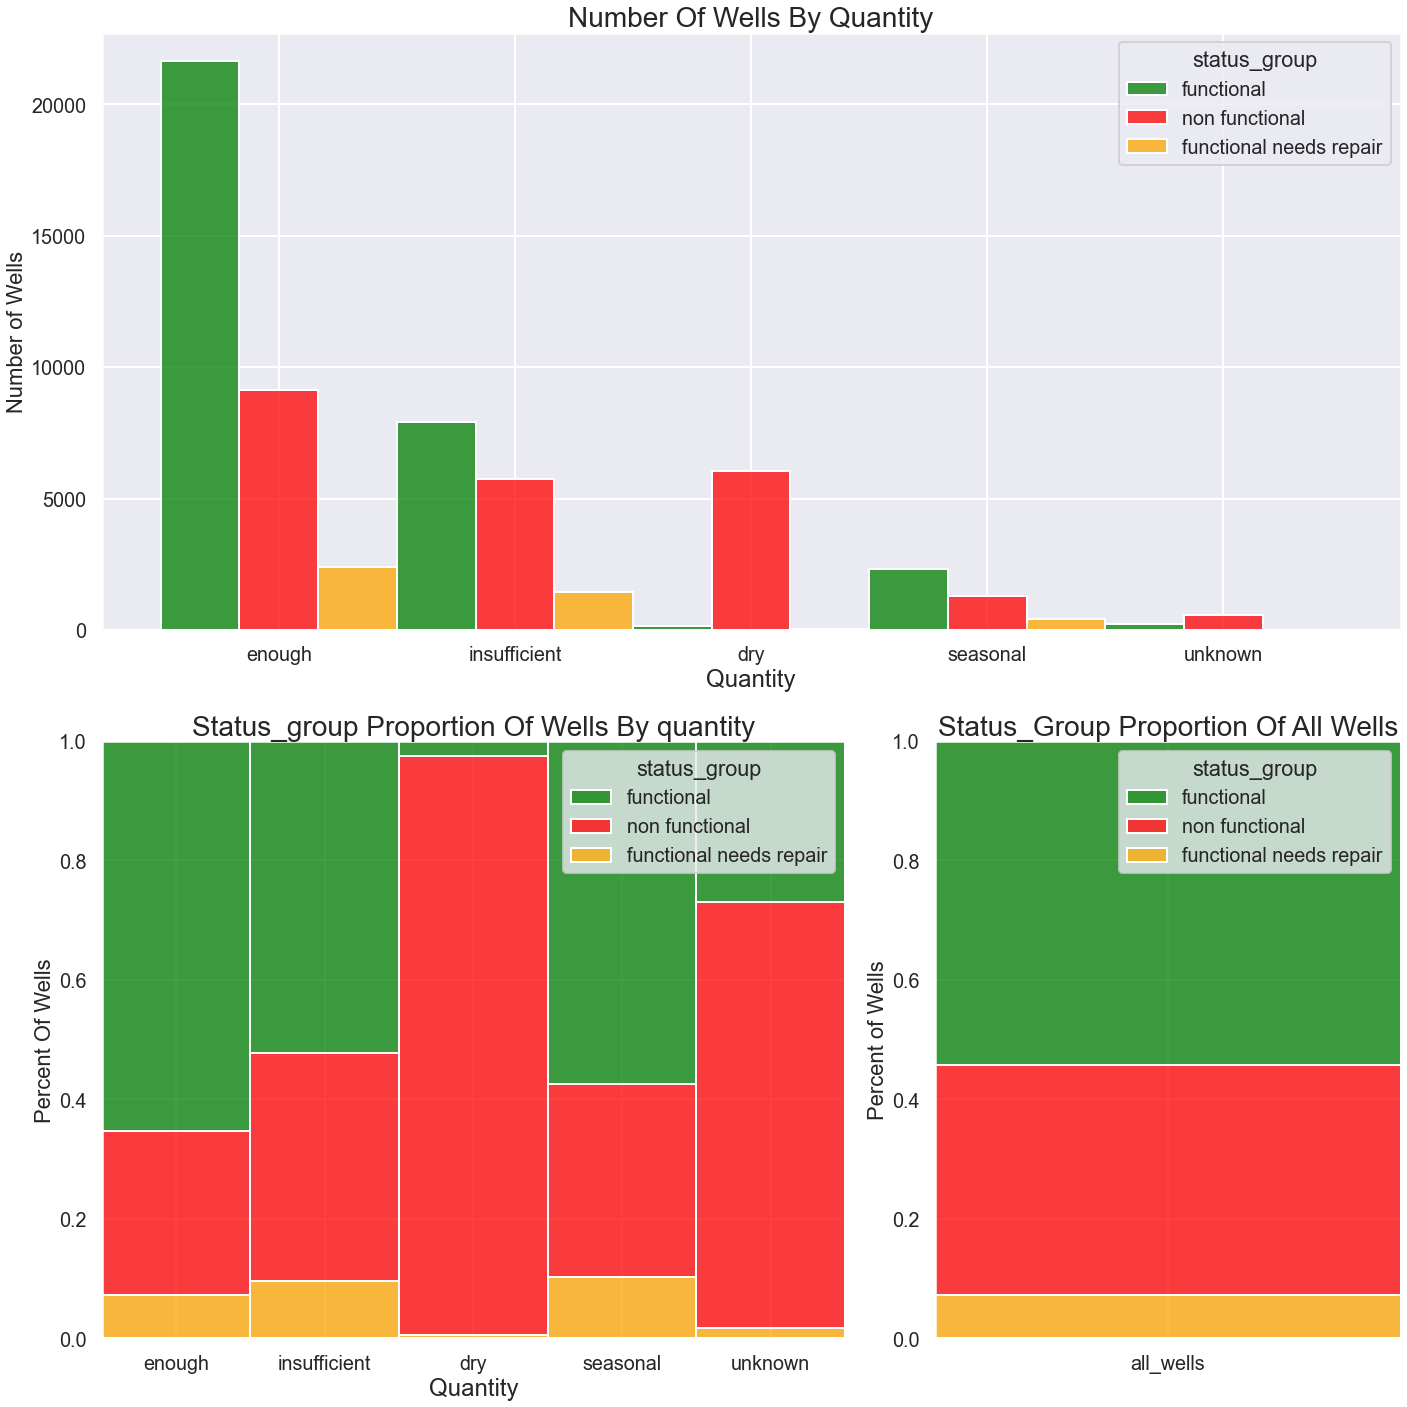

In [112]:
# change the seaborn context for clearer and easier to read visuals
sns.set_context('poster', font_scale = .9)

# run our funtion
plot_continuous_comparison(dfPreprocessed, 'status_group',[important_features[0]], colorDict);

#increase visual appeal with tight_layout. 
plt.tight_layout()
plt.show()

The enough label for the quantity feature tops the list for magnitude. With a comparison to the distribution of our target classification we see that the wells with the enough quantity are somewhat more likely to be functional and slightly less likely to be non-functional than the overal status group distribution. 

The insufficient quantity is only marginally different from the overal distribution.

The dry quantity on the other hand heavily favors the non-functional classification.

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


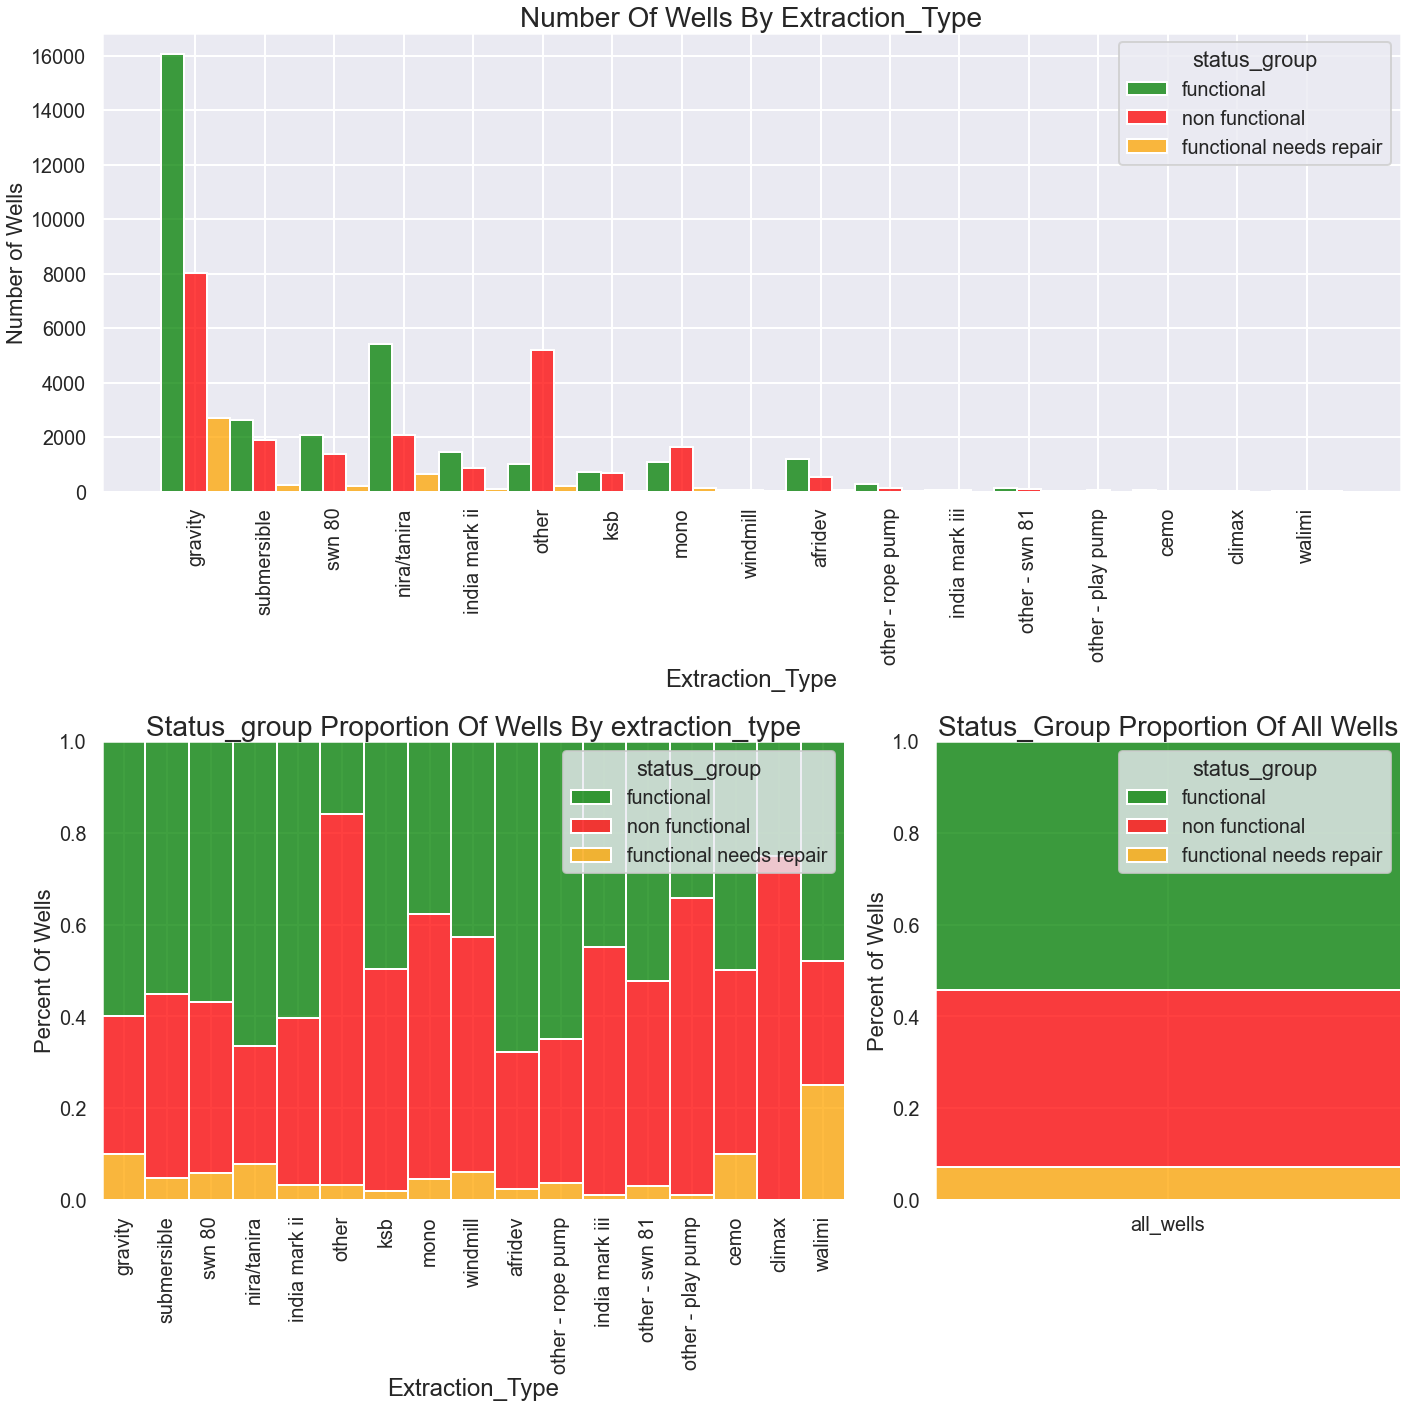

In [113]:
plot_continuous_comparison(dfPreprocessed, 'status_group',[important_features[1]], colorDict, verticalLAbels=True);
plt.tight_layout()
plt.show()

In addition, those with the extraction_type other are overwhelmingly non functional.

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


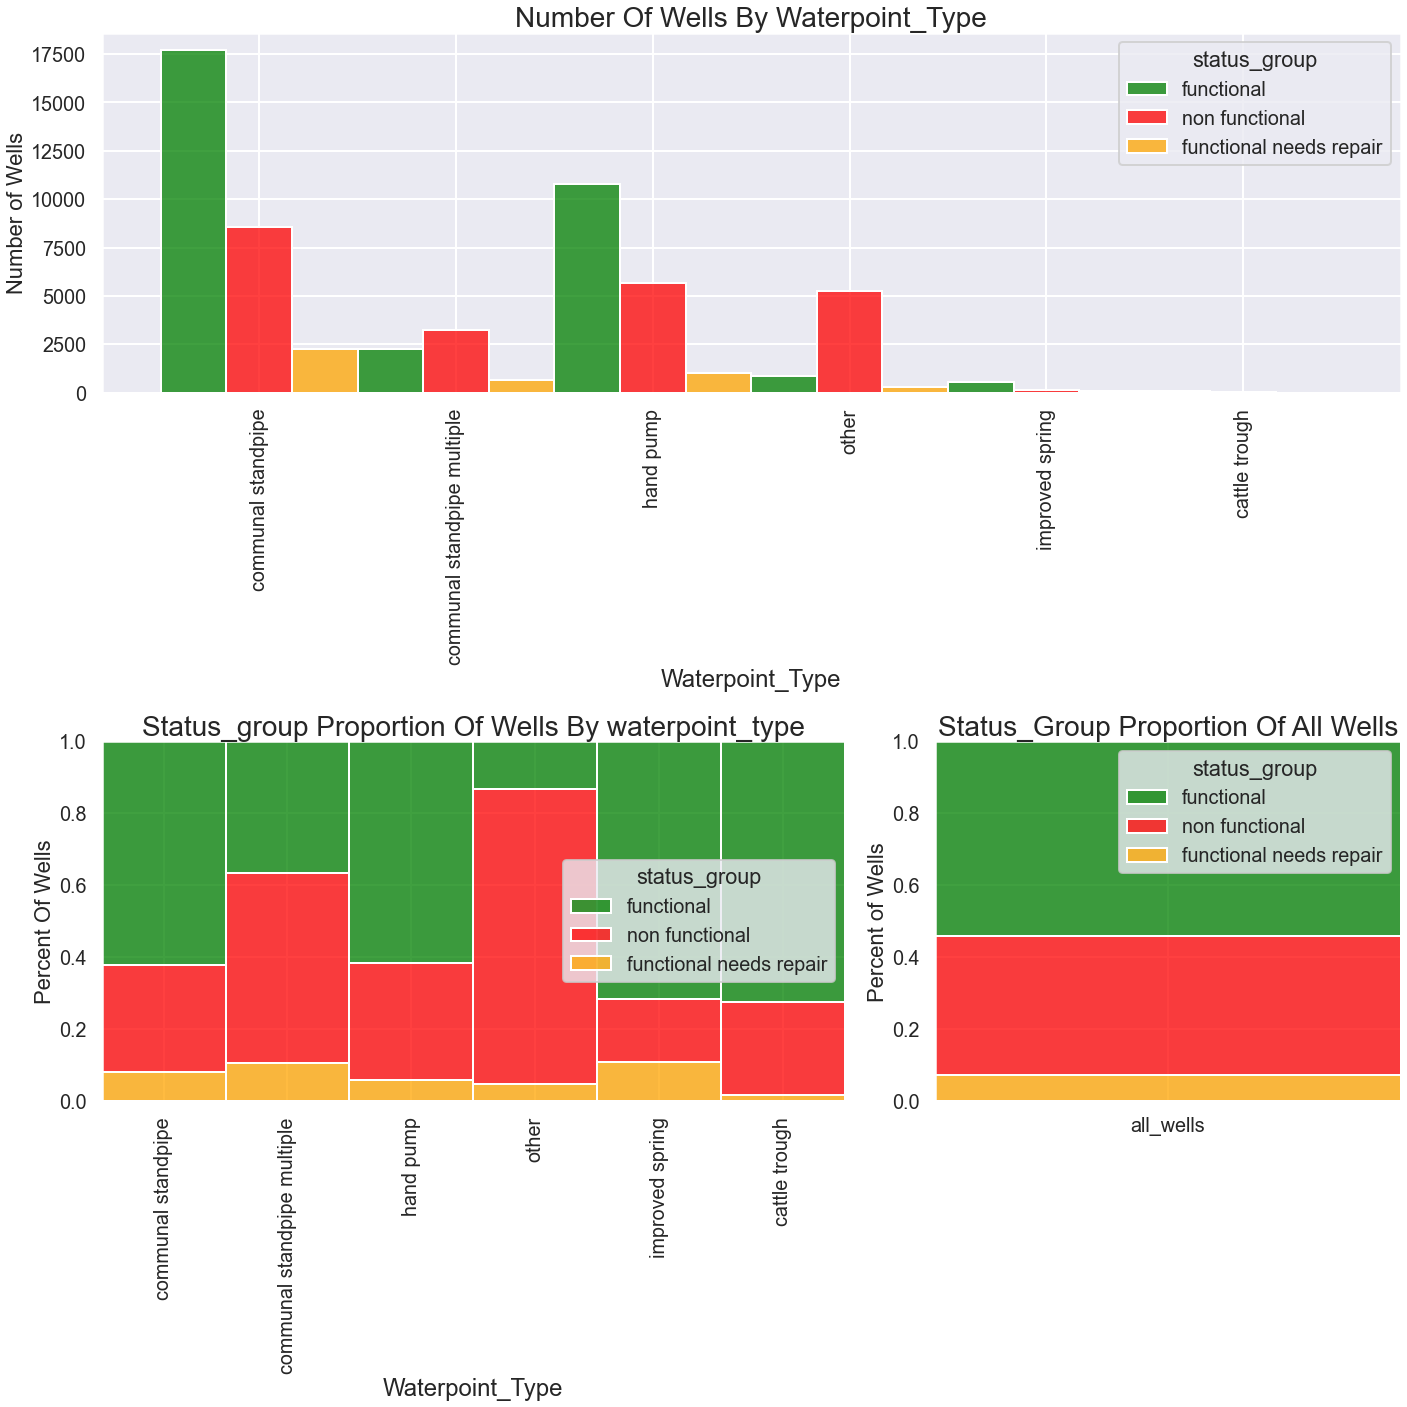

In [114]:
plot_continuous_comparison(dfPreprocessed, 'status_group',[important_features[2]], colorDict, verticalLAbels=True);
plt.tight_layout()
plt.show()

Wells that employ a gravity feed system are also slightly favored to be functional vs non-functional. There also appears to be a slight increase in needs repairs.

Those that fall under the other type for waterpoint_type are incredibly likely to be non functional wells. 

Wells with the communal standpipe multiple layout are majority non functional. There is also a preceivable increase in the wells that are needing repair.

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


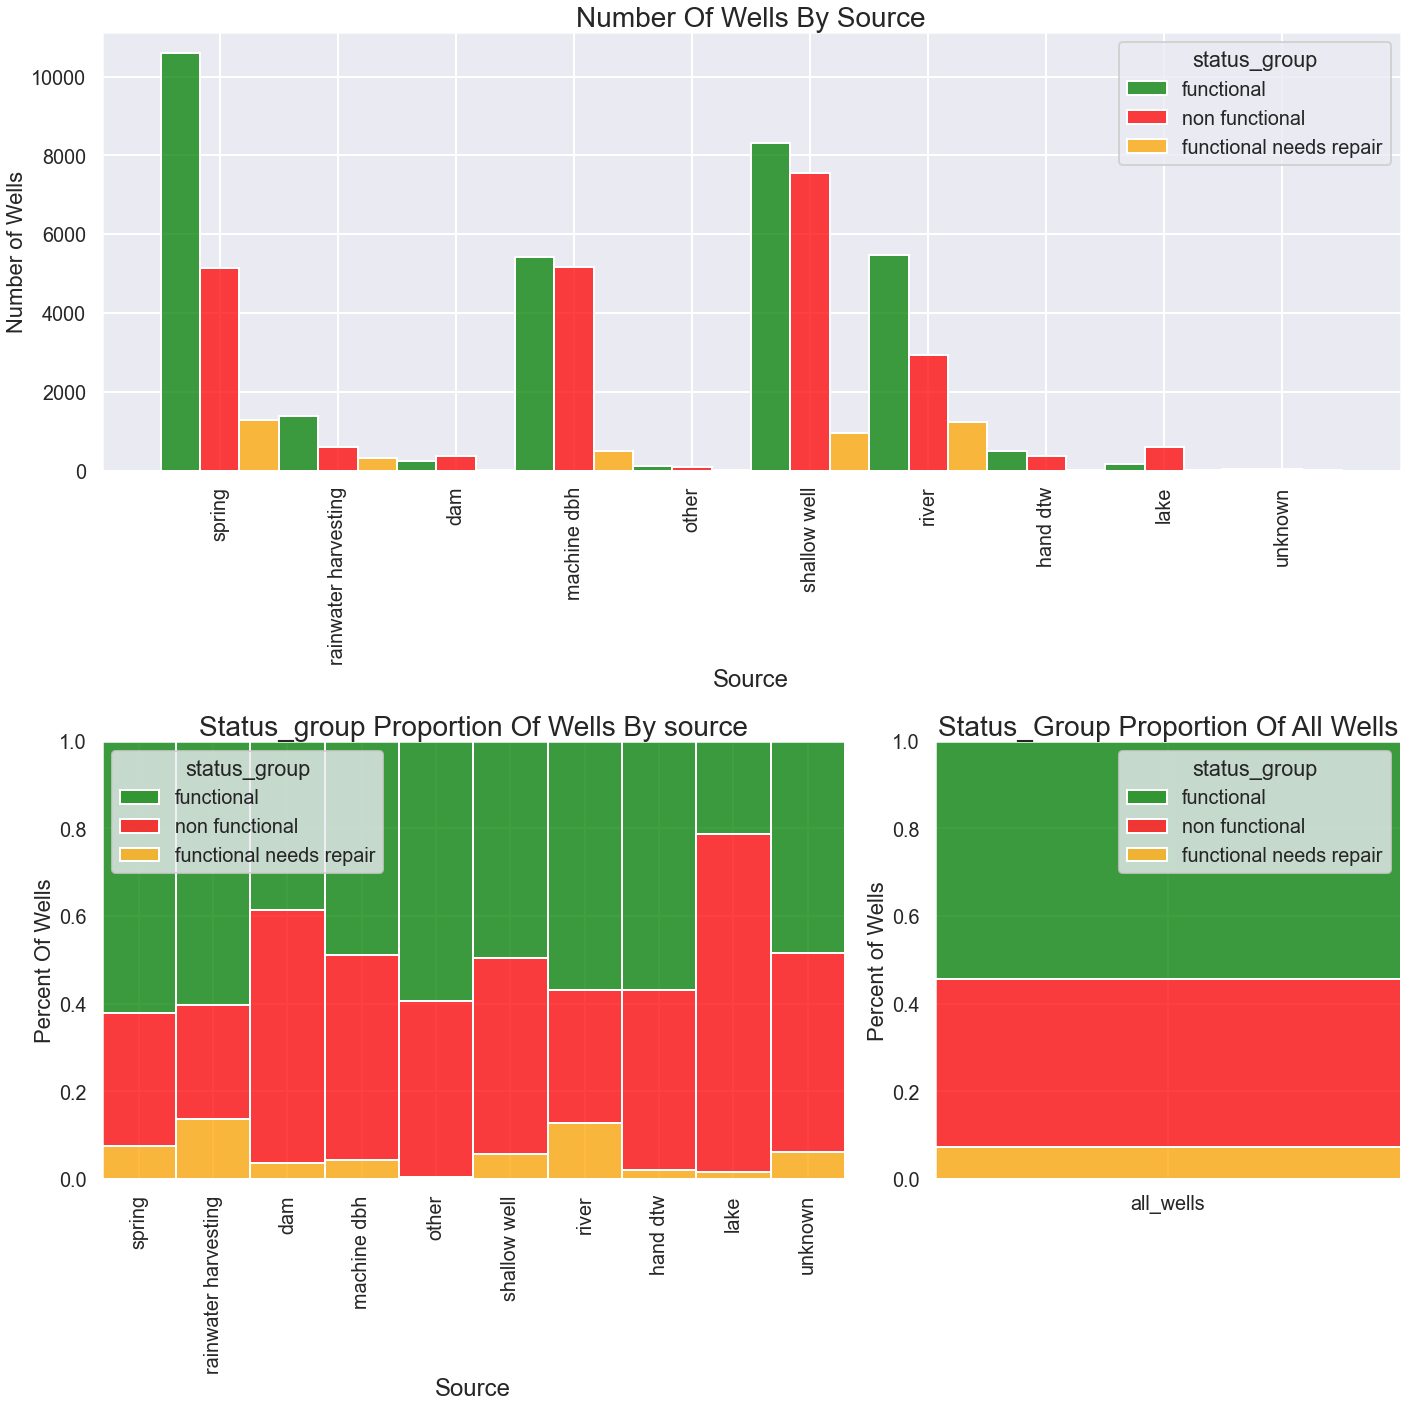

In [115]:
plot_continuous_comparison(dfPreprocessed, 'status_group',[important_features[3]], colorDict, verticalLAbels=True);
plt.tight_layout()
plt.show()

Being sourced by a river makes a well almost double as likely to be needing repair, however, river sourced wells appear to have high functionality rates than the average. 

Similary with wells that are of the communal standpipe form. 

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


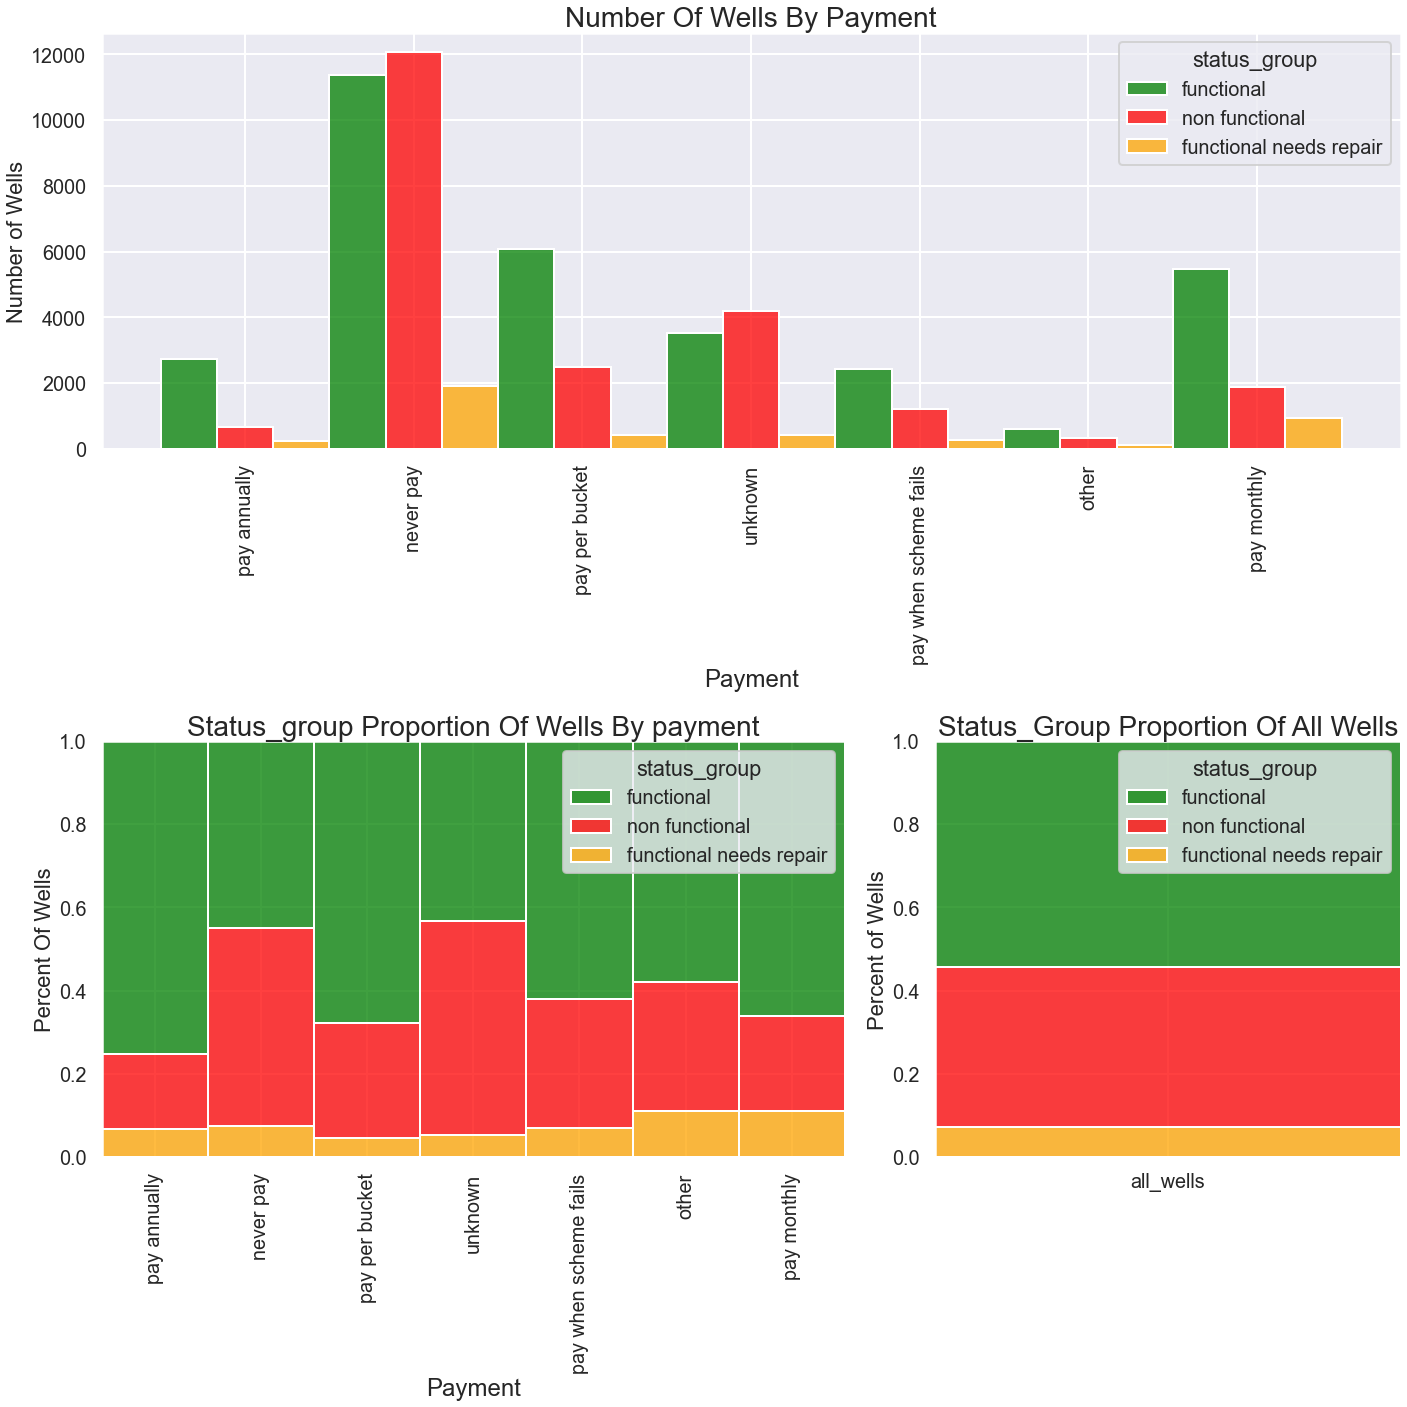

In [116]:
plot_continuous_comparison(dfPreprocessed, 'status_group',[important_features[4]], colorDict, verticalLAbels=True);
plt.tight_layout()
plt.show()

Wells that are on a never pay system are significantly more likely to be non-functional than average.
Wells that are on a pay per bucket system are more inclined to be functional and needing little repair. 

### Continuous Feature Importance

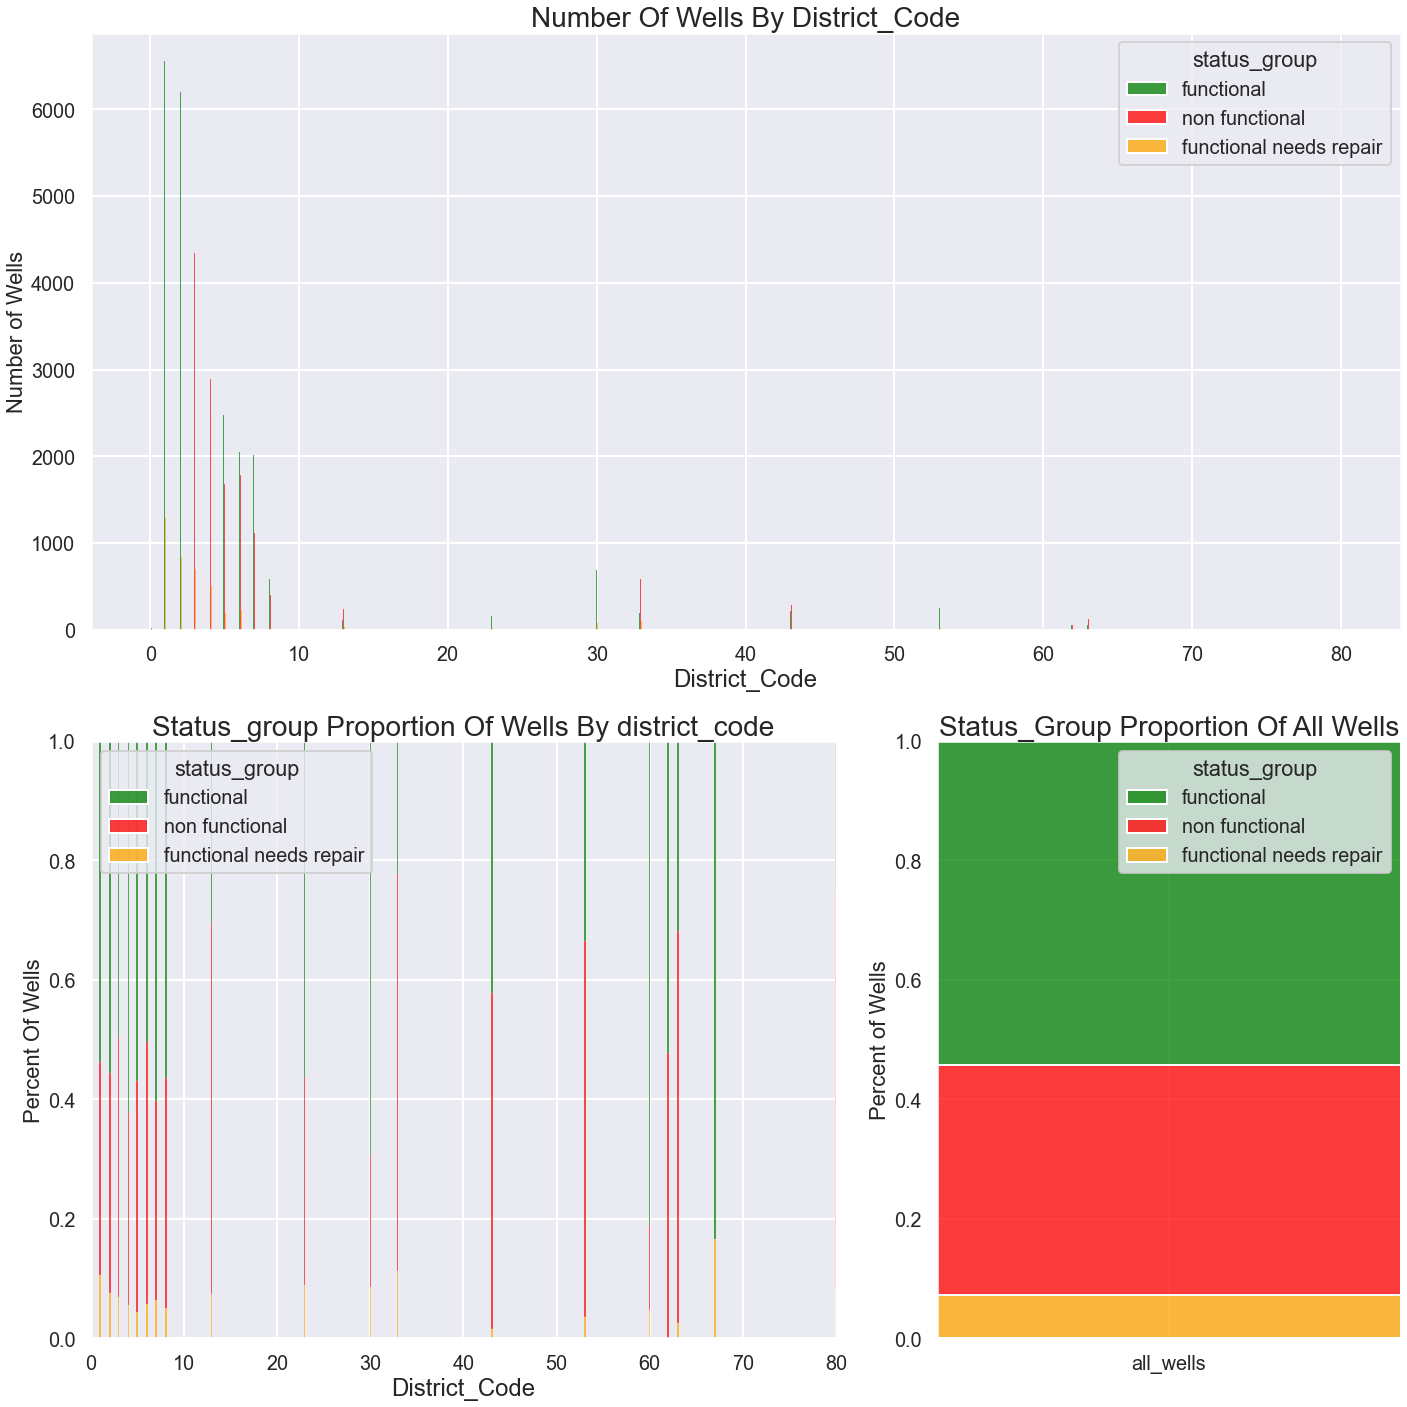

In [117]:
dfPreprocessed.district_code = dfPreprocessed.district_code.astype('O')
plot_continuous_comparison(
    dfPreprocessed, 
    'status_group', 
    ['district_code'], 
    colorDict
)
plt.tight_layout()
plt.show()

Districts are more diverse in their makeups. Distric 3 appears to hae a higher likelihood to have non-functional wells when compared to other districts of similar sizes. Distric 6 is much the same. Whereas district 4 and 30 have more functional wells. Rare but still with approximately 1000 wells are districts 33 and 53. Both these districs are more likely to have non-functional wells than functional ones.

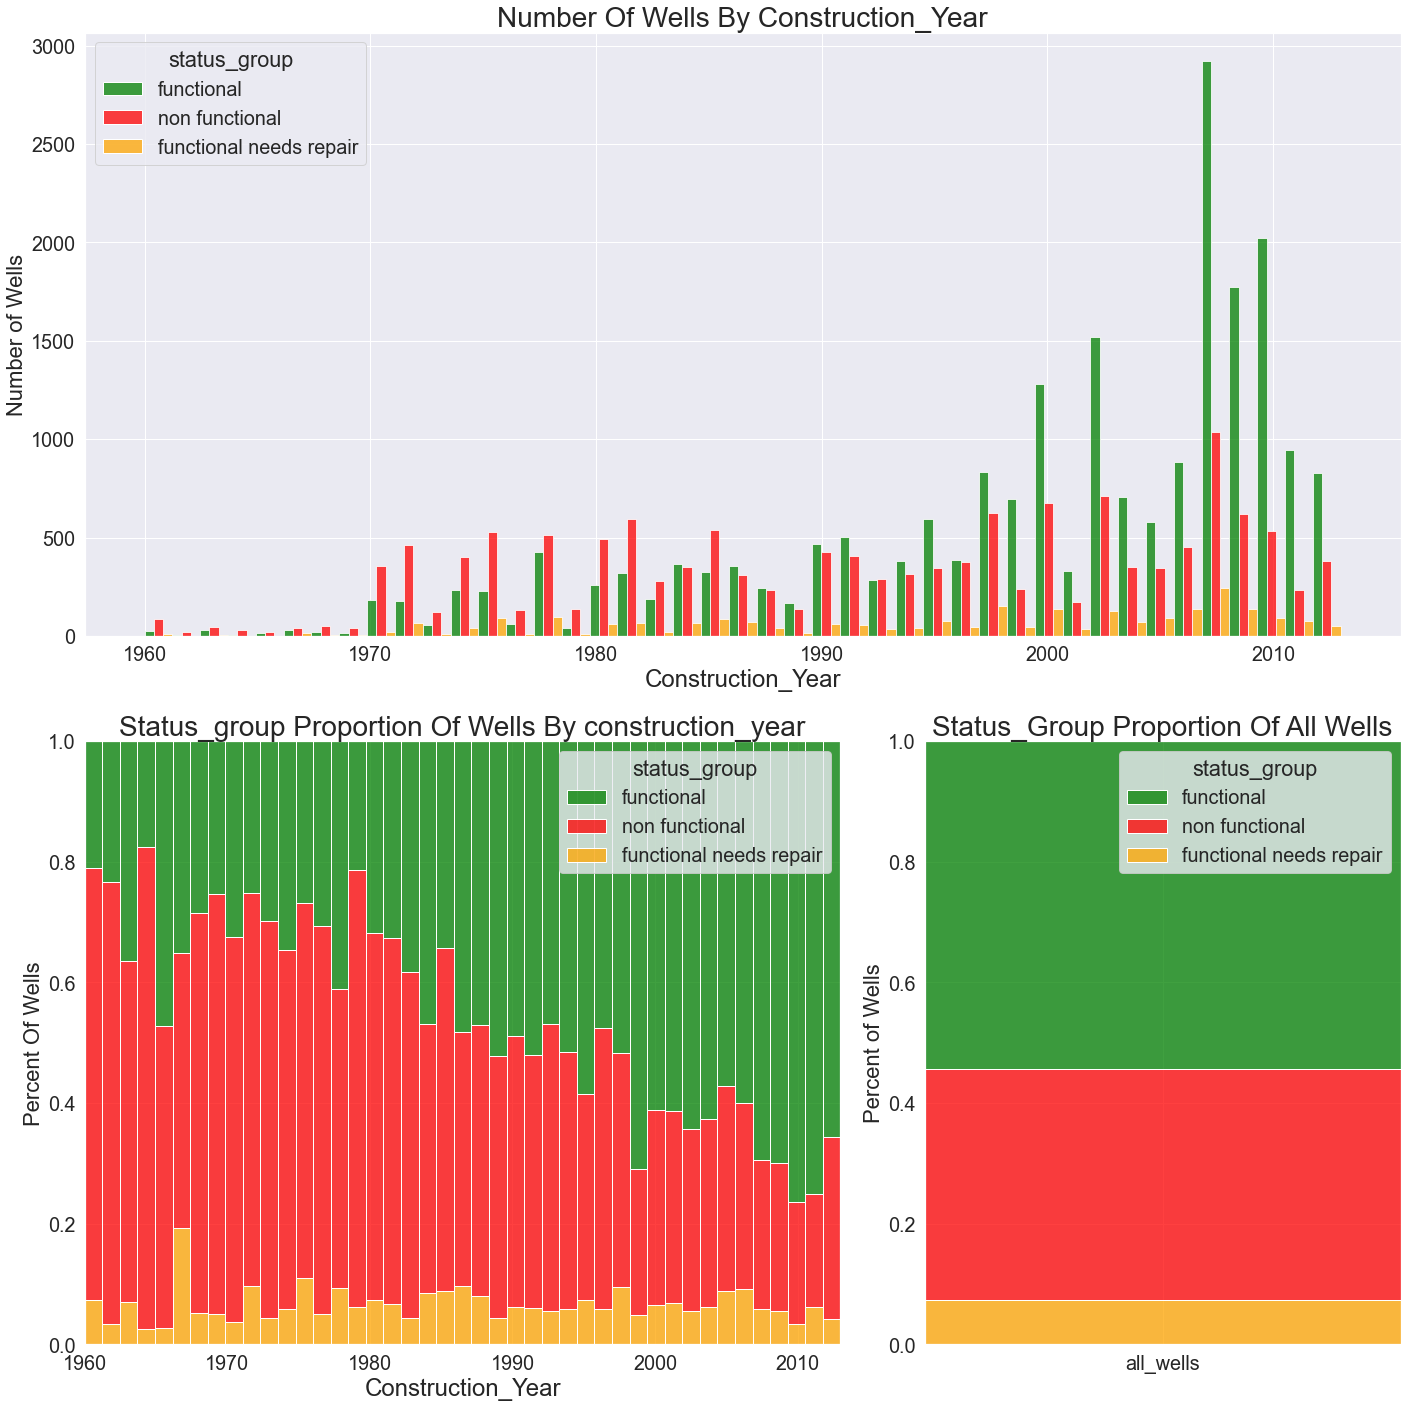

In [118]:
sns.set_context('notebook', font_scale = 1.8)
plot_continuous_comparison(dfPreprocessed, 'status_group', ['construction_year'], colorDict)
plt.tight_layout()
plt.show()

Some what intuitively, older wells are much more likely to be non-functional than new ones. Paralleling this, older wells are more likely to be functional but needing repairs that more modern wells. There appears to be a tipping point late 1980 and early 1990s where wells appear to be both functional and non-functional equally likely. 

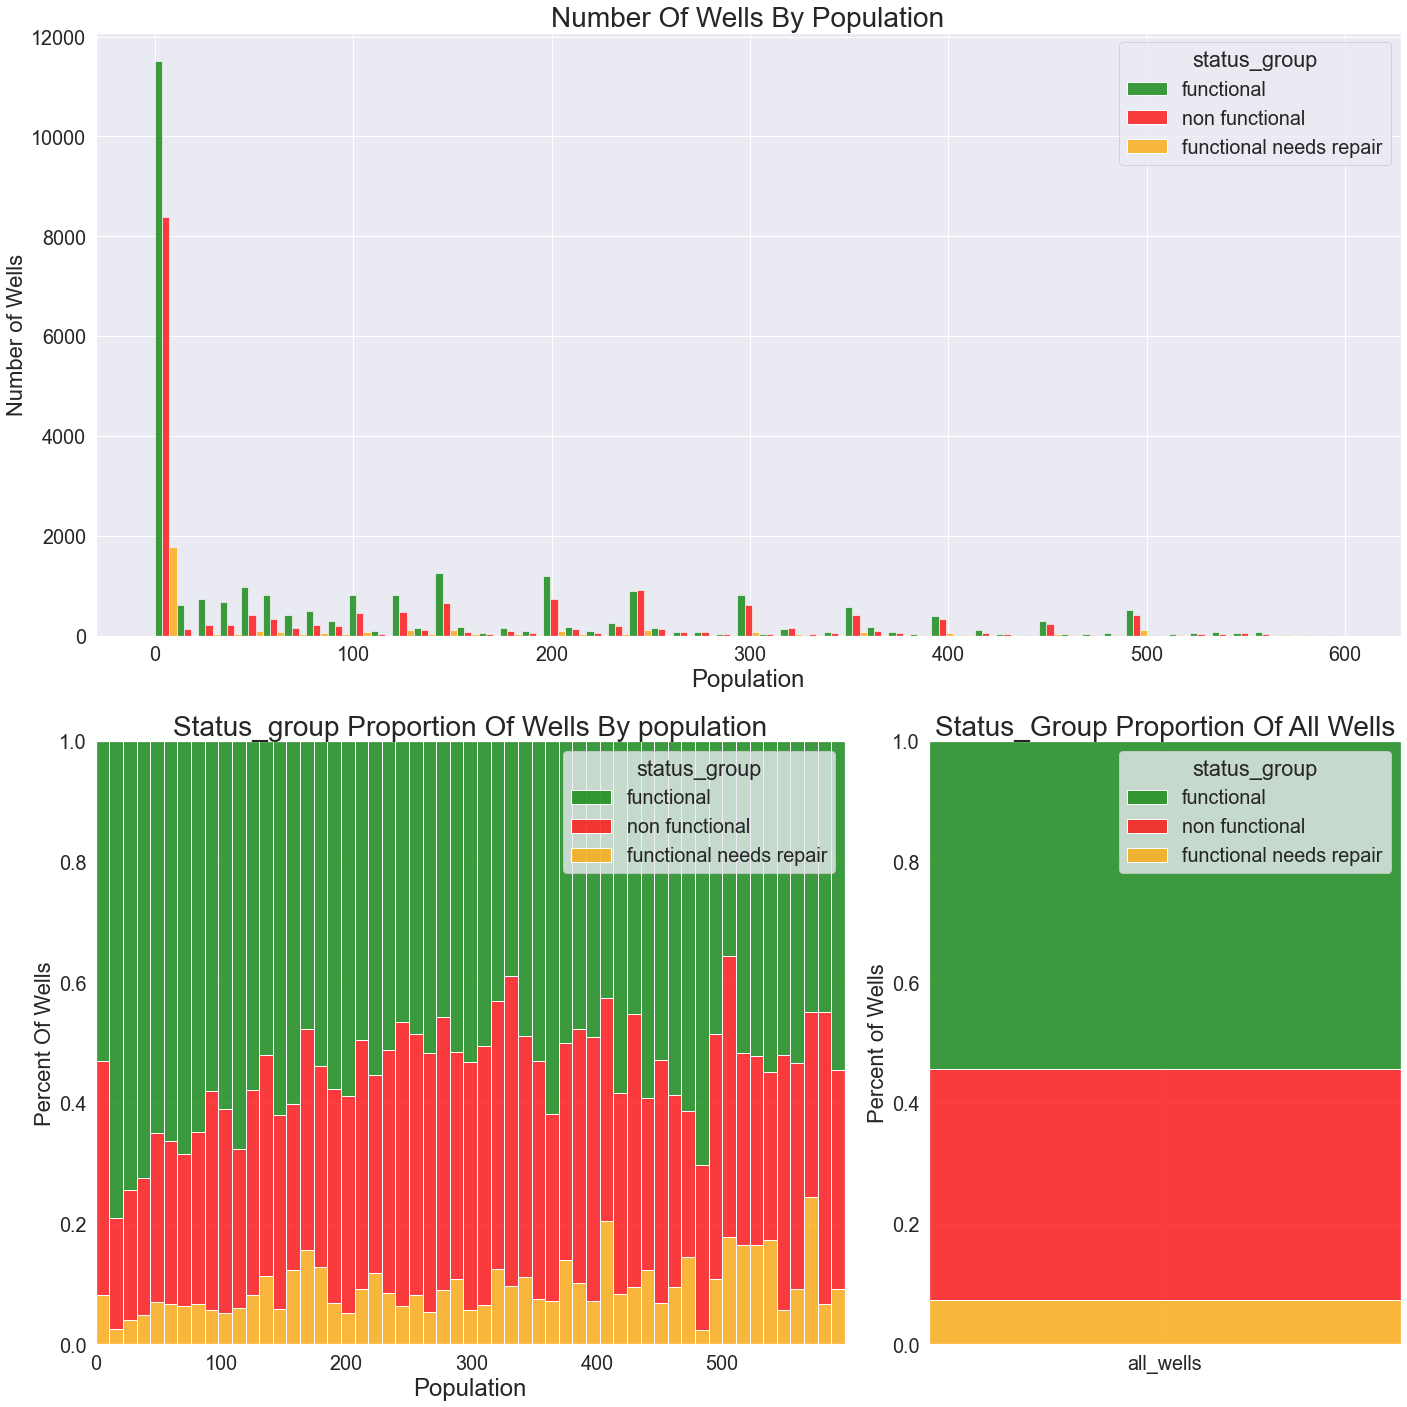

In [124]:
plot_continuous_comparison(dfPreprocessed.loc[dfPreprocessed.population < 600], 'status_group', ['population'], colorDict)
plt.tight_layout()
plt.show()

There are some other interesting population bins that elucidate the other target labels as well. As population grows beyond 200, it seems that no label has a plurality, or in other words functional is a less likely label than average. Note that the view is truncated at 600 for benefit the visual. There are very few data points beyond this scale.

The second graph confirms that the functional needs repair label is not more prevalent in the low populations areas. 

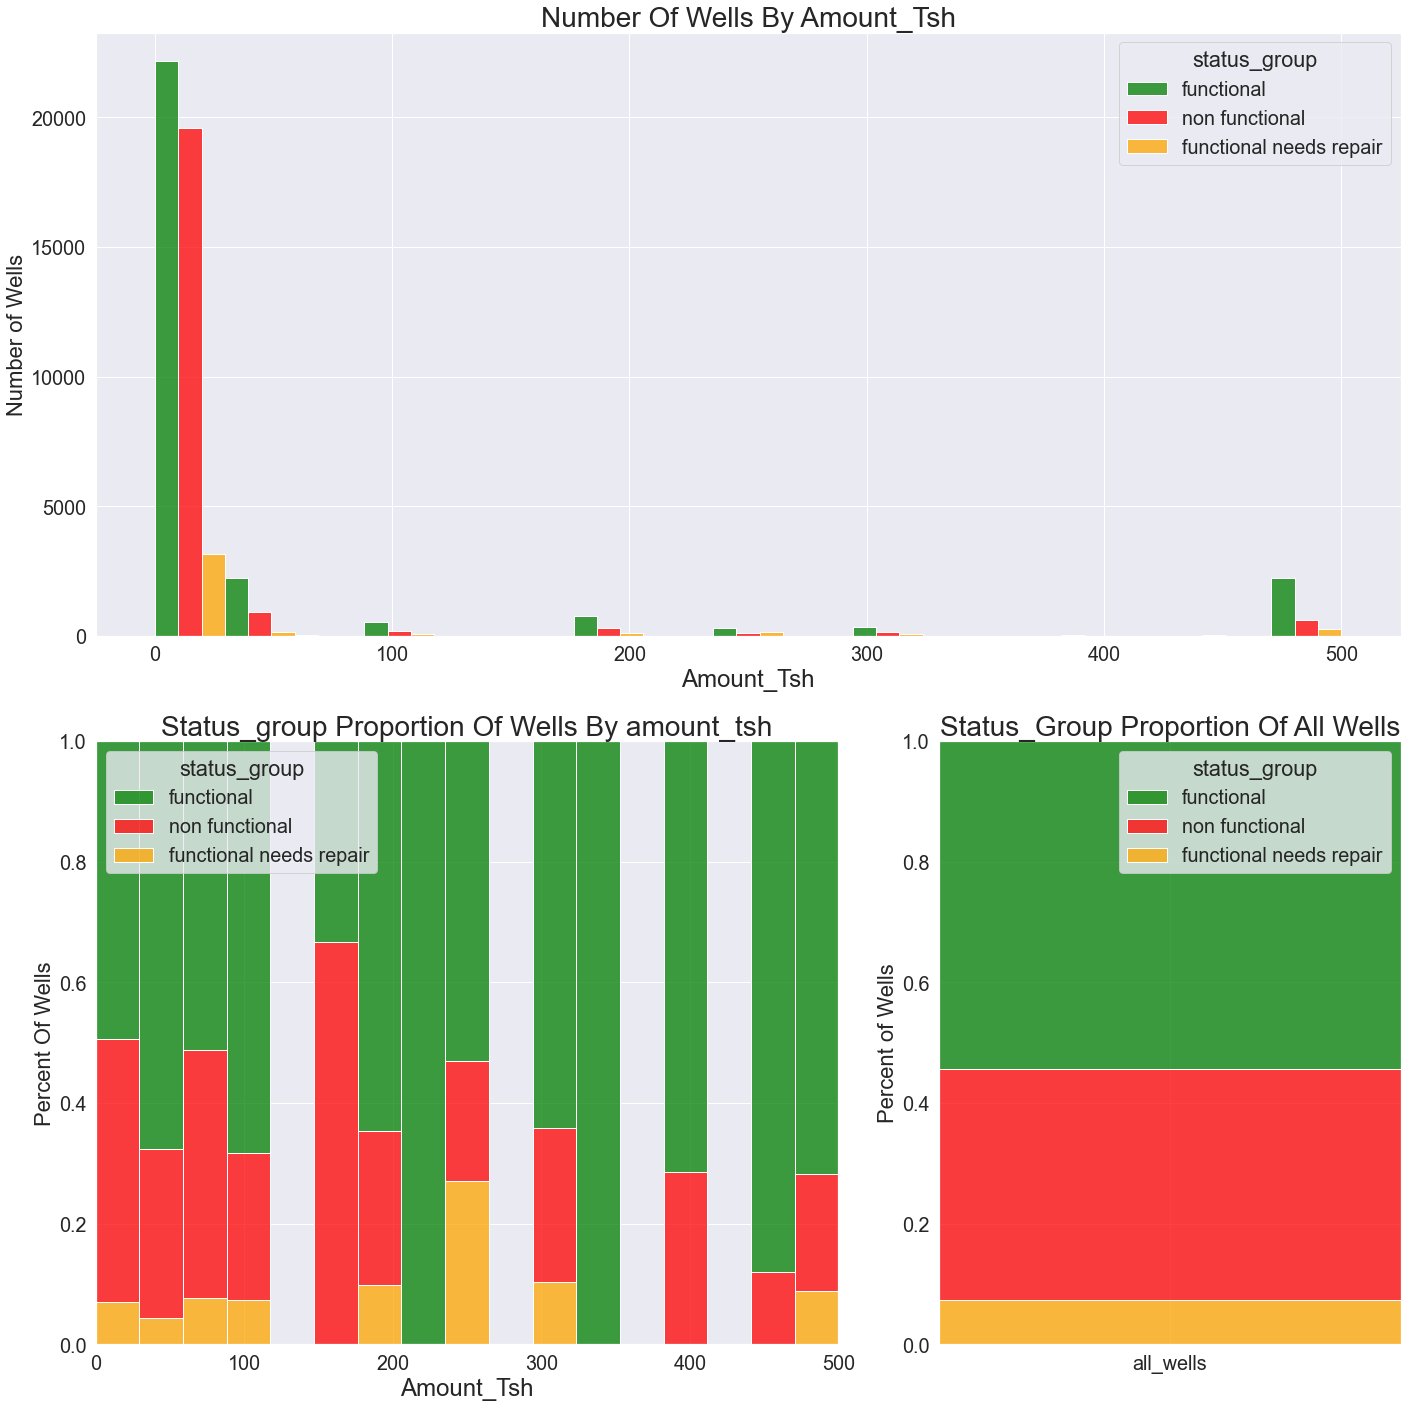

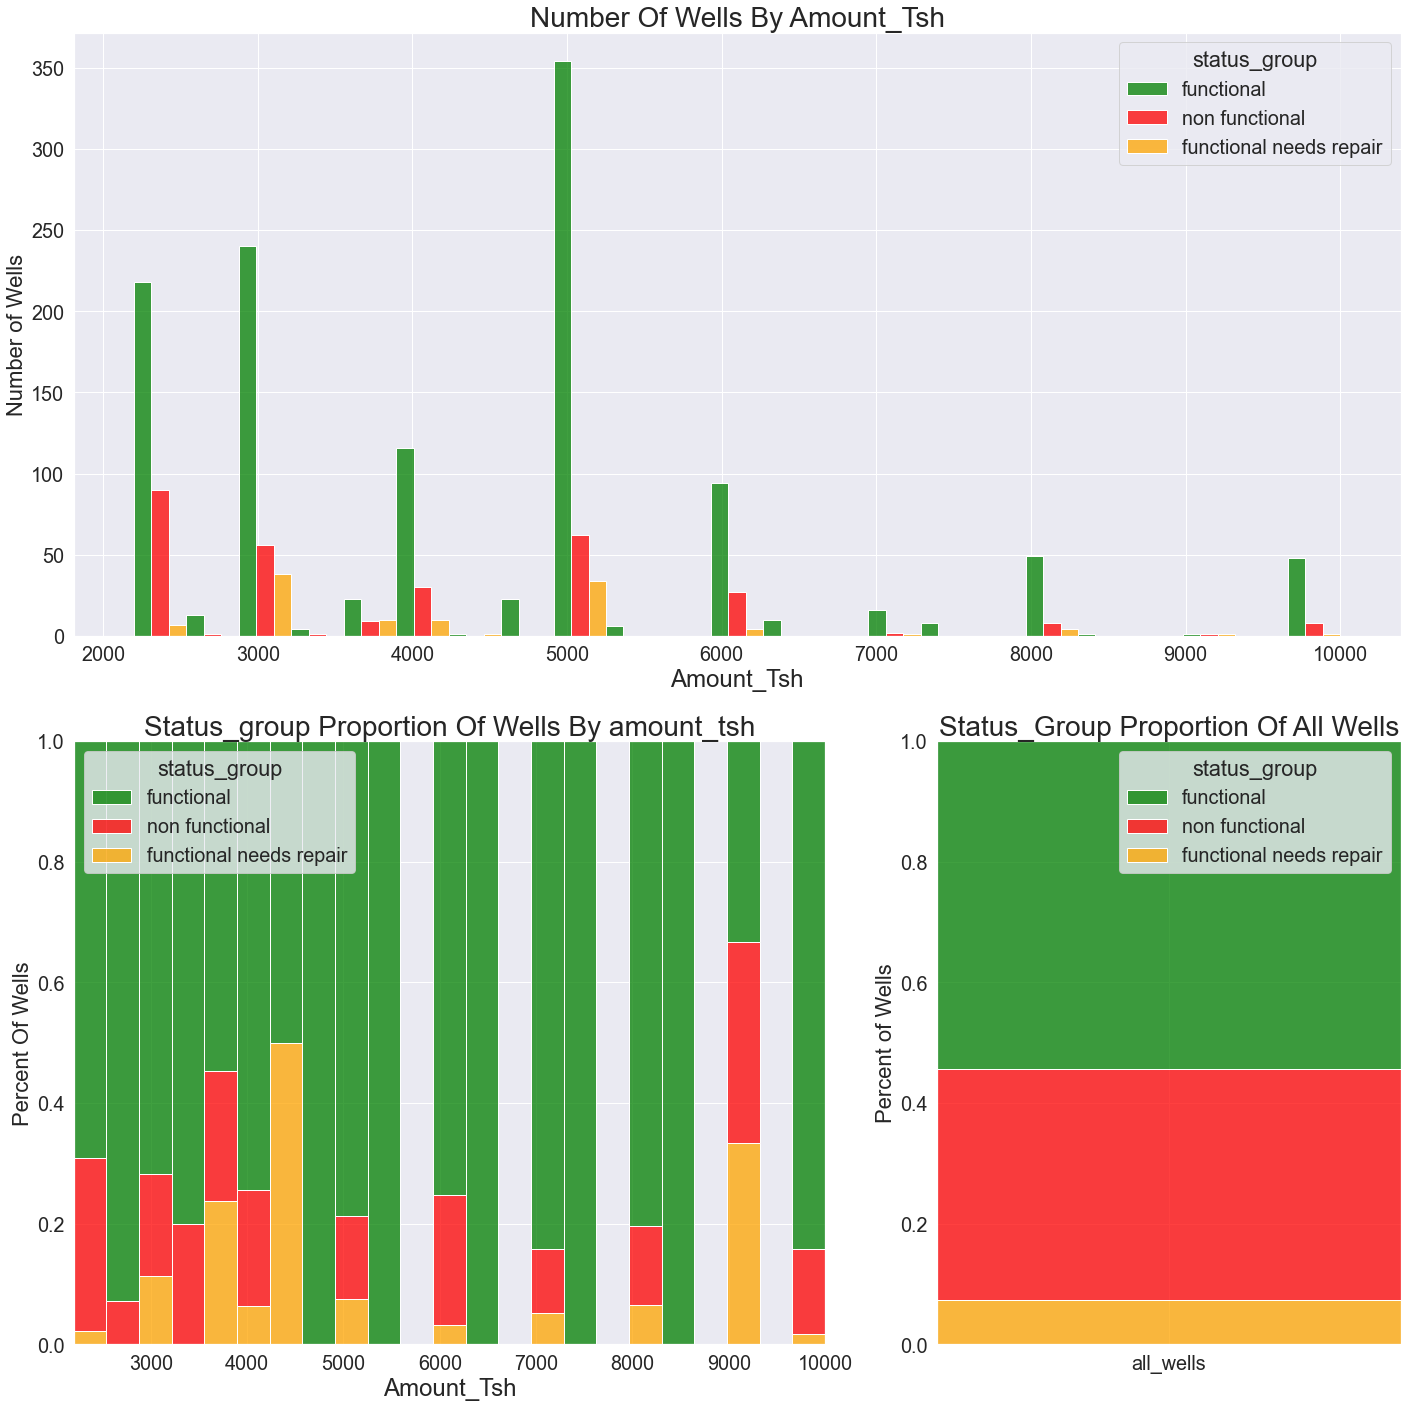

In [120]:
plot_continuous_comparison(
    dfPreprocessed.loc[dfPreprocessed.amount_tsh <= 500], 
                       'status_group', 
                       ['amount_tsh'], 
                       colorDict)
plt.tight_layout()
plt.show()
print()
print()
print()
plot_continuous_comparison(
    dfPreprocessed.loc[(dfPreprocessed.amount_tsh > 2000)&(dfPreprocessed.amount_tsh <=10000)], 
                       'status_group', 
                       ['amount_tsh'], 
                       colorDict)
plt.tight_layout()
plt.show()

Note the differences in scale in the previeous figures. For wells with no thyroid hormone present, there is a slightly increased chance from the average that the well is non-functional. Other than the 0 reading, with rare exception, virtually all wells are heavily favored to be functional when compared to the average. This to me suggests that the zero entry for the amount_tst column is an imputed value that was missed by our original preprocessing. It was originally included as a valid entry due to the pressense of very small tsh levels being present in the data set. For future research it would be worth re-evaluating the model, replacing these values with a summary statistic from the training data for the amount_tsh column. 

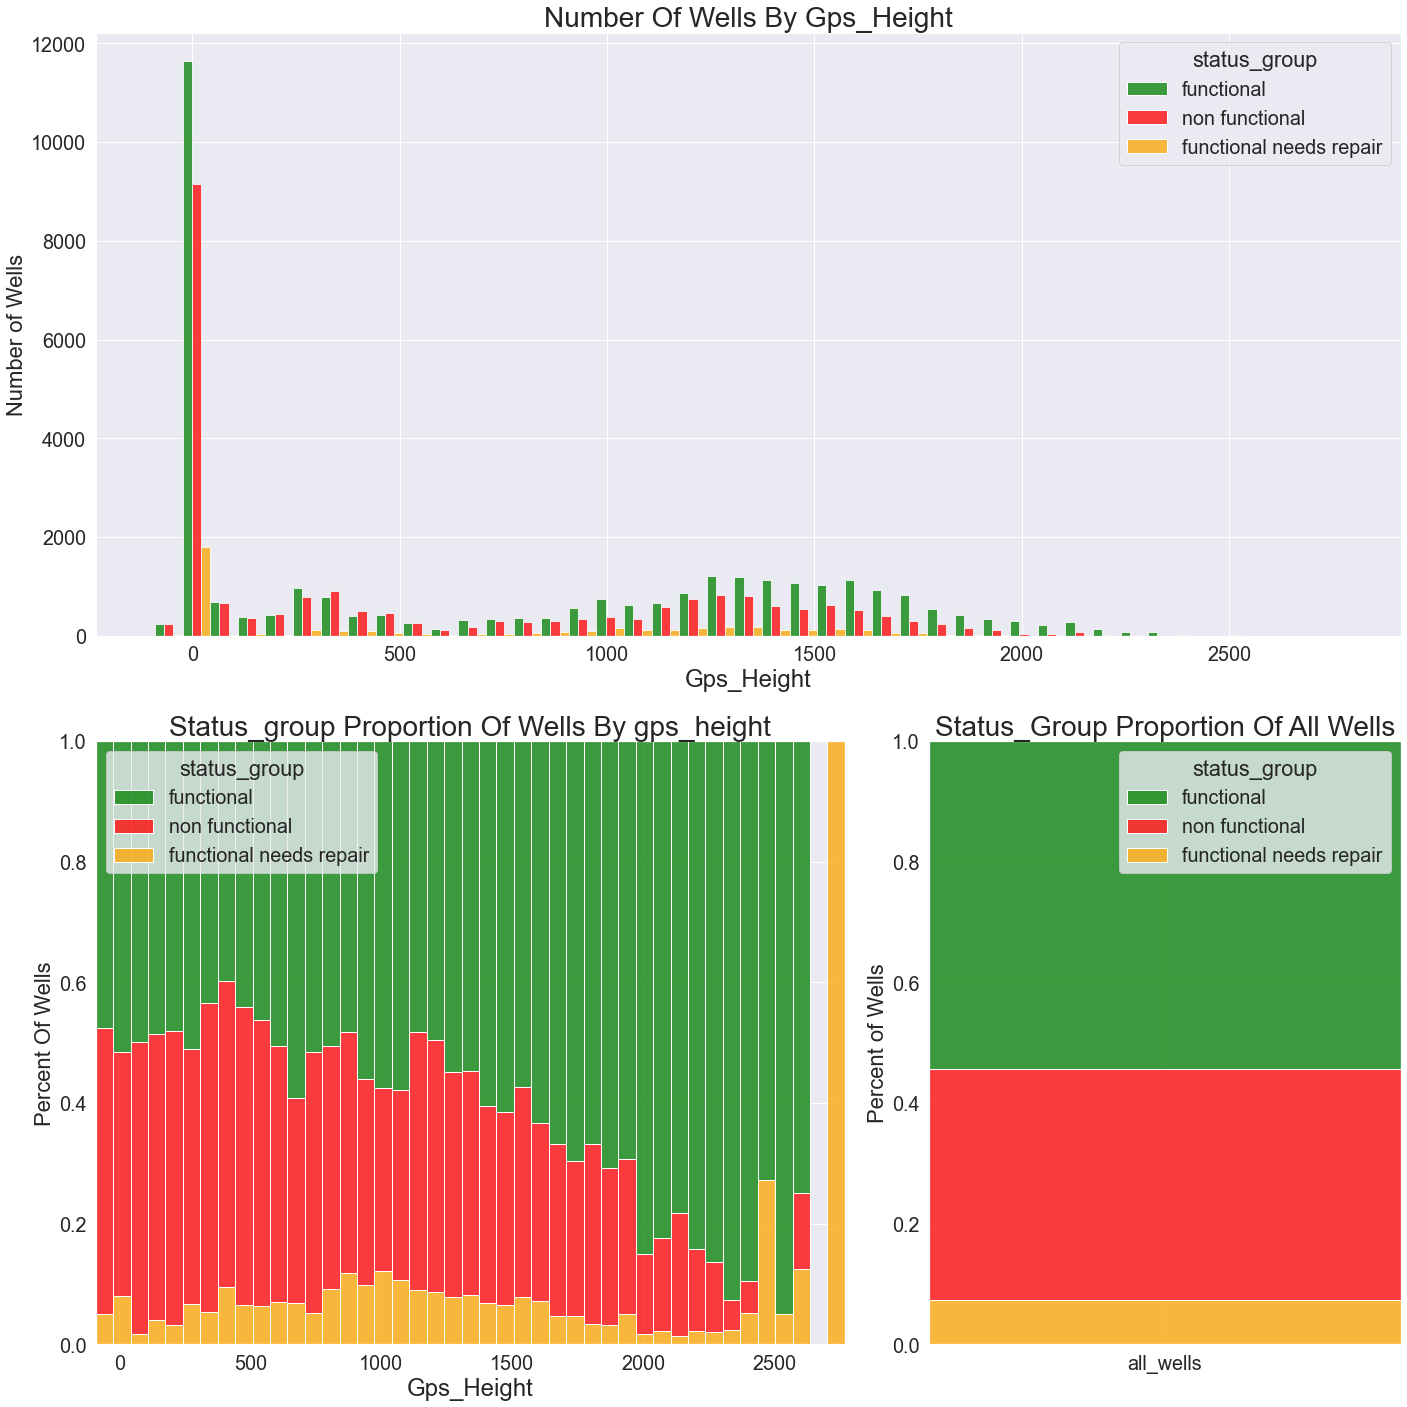

In [121]:
plot_continuous_comparison(dfPreprocessed, 'status_group', ['gps_height'], colorDict)
plt.tight_layout()
plt.show()

The gps' with heights less than 500 appear to be more likely than average to be non-functional. Whereas, gps' with height greater than 1300 feet are most likely to be functional. 

### Geo-Location Feature Importance

Geo Location ranked prominently among the important features. We will import an image made from tableau public to give a better look at the geography of the status group.
<img src = './geo_location.png'>
Several of the southern and central regions have distinct areas where wells are non-functional. These sections should be targeted for maintenace construction and remediation.

## General Conclusions

There are enough insights here to derive some useful insights and action items. Here's the quick and dirty version of this reports conclusions. Note that only the top 20 features are considered for this section for limiting the scale of items to a reasonable level. More perfect insight is for the model to infer.
### Wells That Are Likely Broken
* Qyantity : dry
* construction_year < 1985
* Are located near the non-functional clusters as shown on the Geo-Location map. 
* Have negative gps_heights
* excavation_type: communal standpipe multiple, other
* waterpoint_type other
* Payment_type never pay
* district_codes : 33,43,53,63
* gps_height < 500

### Likely To Be Functional Wells
* quantity enough
* source river
* construction_year > 2000
* Payment_type: pay per bucket
* distric_codes : 4, 30
* gps_height > 1250
* amount_tsh > 0

Finding well that are on the boundary category of funtional but needing repairs was a fundamental challenge of this project. The two most important features that appear to offer a clear seperation from the overall data distribution are:
### Well Most Likely To Need Repair
* Gravity excavation type
* river source

These categories imply the wells are slightly more likely to be needing repair than the overal average. 
As with the functional category, wells that have the dry quantity rating are very unlikely to be needing repair. 

# Recommendations

The feature importance evaluation has opened much in the way of business action items. The following are not listed in any particular order but some have more easily realized potential than others.
## 1
### Additional site analysis before building or rebuilding wells that are labelled (or likely to be labelled) dry.
## 2
### If wells must be built in areas that are likely to run dry, perhaps alternative water sources should be explored
## 3
### New builds should avoid well types that would fall under the other category.
## 4
### Retro-fit old wells that are extraction_type other if possible.
## 5
### Gravity wells should be reconsidered as the primary well extraction type due to maintenance issues.
## 6
### New builds and retro-fits should avoid the communal standpipe multiple and other types as the waterpoint. 
## 7
### Wells older than 1990 should be targeted for rebuilds
## 8
### Wells constructed in the 1990s should be placed on maintenance schedules to limit additional non-functionality
## 9
### When planning a well in any given area. Lean towards picking locations with higher elevations.
## 10
### Build well with surrounding populations in the range: 115 > population  > 8.
## 11
### Further investigate before adding or rehabilitating wells in non-functional clusters by geo-location.
## 12
### Screen for tsh. Non-zero tsh wells are more likely to be functional.
## 13
### Wells should be set up under the pay per bucket system and not the never pay system.

# Things Not Given The Proper Attention They Deserve!

At the end of every project there are things left unsaid or unexplored. The following is a list of the items I believe to merit further investigation in no order whatsoever
* Data Understanding - Many of the columns involve industry specific verbage that is hard to parse. More research is needed to understand exactly what the features are to provide better insight into how to preprocess. 
* Imputation techniques - This project only used two types of imputation techniques. Specifically KNN Imputation should be explored.

# Deployment/Submissions

In [ ]:
testData = pd.read_csv('data/water_wells.csv')
testData

In [ ]:
# we store the encodded columns in a variable for for straight forward integration
reduced_columns = frequency_encoding(testData[catColsToTrim])

# loop through and create new columns with the encodded data
for column in testData[catColsToTrim].columns:
    tempColumn = testData[column].map(reduced_columns[column])
    testData[f'encoded_{column}'] = tempColumn
    
for column,value in {'scheme_management' : 'None', 
                     'extraction_type' : 'other - mkulima/shinyanga', 
                     'waterpoint_type' : 'dam'}.items():
    testData[column] = replace_value(testData, column, value, 'other')
testData.public_meeting = testData.public_meeting.map(true_false_map)
testData.permit = testData.permit.map(true_false_map)
testData['date_recorded'] = pd.to_datetime(testData['date_recorded'])
testData['date_recorded_month'] = [x.month for x in testData['date_recorded']]
testData['date_recorded_year'] = [x.year for x in testData['date_recorded']]
testData['date_recorded_day'] = [x.day for x in testData['date_recorded']]
testData['date_recorded_day_of_week'] = [x.weekday() for x in testData['date_recorded']]
dataFirstDrop = testData.drop(columns = catColsToTrim)
dataSecondDrop = dataFirstDrop.drop(columns = columnsToDrop)
# slice out the continuous columns
dataContinuousColumns = dataSecondDrop.select_dtypes(['int64', 'int32', 'float64', 'float32']).drop(columns = ['public_meeting', 'permit'])

# run a loop to get the z-scores for each column
zScoresArray = []
for column in dataContinuousColumns.columns:
    zScoresArray.append(zscore(dataContinuousColumns[column]))
    
# make a pretty dataframe
dfZScores = pd.DataFrame(np.transpose(zScoresArray), columns = dataContinuousColumns.columns)

numPrivateOutliers = dfZScores.num_private.loc[dfZScores.num_private > 3]
numPrivateOutliers
amount_tshOutliers = dfZScores.amount_tsh.loc[dfZScores.amount_tsh > 3]
amount_tshOutliers
indiciesToDrop = list(numPrivateOutliers.index)
for x in amount_tshOutliers.index:
    indiciesToDrop.append(x)
indiciesToDrop = list(set(indiciesToDrop))
dataThirdDrop = dataSecondDrop.drop(index = indiciesToDrop)
# Create a list of the colums which will be reverted and a list of the improperly imputed data
listToFill = ['longitude', 'latitude', 'population', 'construction_year']
listOfFill = [0, -2e-8, 0, 0]

#Zip the lists for easy looping
zipOfFill = zip(listToFill, listOfFill)

# Loop through and revert the columns
for column,value in zipOfFill:
    dataThirdDrop[column] = revert_to_na(dataThirdDrop[column],value) 
    
# Assign the thrid drop to move to the next stage    
dataThirdDrop['population'] = revert_to_na(dataThirdDrop['population'], 1)
dfPreprocessed = dataThirdDrop.copy()
X = dfPreprocessed
X

In [ ]:
def preprocessing(X, imputationMethod = 'simple', sparse_threshold = .3):
        categorical_feature_indecies = X.columns.isin(X.select_dtypes('object').columns)
        continuous_featuere_indicies = X.columns.isin(X.select_dtypes(['int64','float64']).columns)
        continuous_features = X.select_dtypes(['int64', 'float64','int32', 'float32'])
        categorical_features = X.select_dtypes(['object', 'category'])

        if imputationMethod == 'simple':
            pipelineContinueous = IMBPipeline(steps = [
                ('impute', SimpleImputer(strategy = 'median')),
                ('scaler', skp.StandardScaler())])

            pipelineCategorical = IMBPipeline(steps = [
                ('impute', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
                ('onehot', skp.OneHotEncoder())])

        elif imputationMethod == 'knn':
            pipelineContinueous = Pipeline(steps = [
                ('impute', KNNImputer(weights = 'uniform')),
                ('scaler', skp.StandardScaler())])

            pipelineCategorical = Pipeline(steps = [
                ('onehot', skp.OneHotEncoder(sparse = False)),
                ('impute', KNNImputer(weights = 'uniform'))])

        columnTransformerPreprocessing = ColumnTransformer(
            transformers = [('continuous',pipelineContinueous,list(continuous_features.columns)),
                            ('categorical',pipelineCategorical, list(categorical_features.columns))],
            sparse_threshold=sparse_threshold)
        return columnTransformerPreprocessing

X_preprocessed = preprocessing(X).fit_transform(X)
catfeatureNames = preprocessing(X).transformers_[1][1].steps[1][1].get_feature_names(categorical_features.columns)
contFeatureNames = continuous_features.columns
featureNames = list(contFeatureNames) +list(catfeatureNames)

In [ ]:
(pd.DataFrame(X_preprocessed).sum() == 0).sum()

In [ ]:
y_hat1 = stack1.predict(X_preprocessed)
y_hat2 = stack2.predict(X_preprocessed)

In [ ]:
pd.DataFrame(y_hat1).to_csv('stack1Predictions.csv')
pd.DataFrame(y_hat2).to_csv('stack2Predictions.csv')